In [1]:
import os
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

import matplotlib.pyplot as plt
import seaborn as sns
import anndata

from scroutines import basicu
from scroutines.config_plots import *
import importlib
importlib.reload(basicu)

<module 'scroutines.basicu' from '/u/project/zipursky/f7xiesnm/code/scroutines/scroutines/basicu.py'>

In [2]:
sns.set_context('talk')

In [3]:
outdir = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results/"
outdir

'/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results/'

# get data

In [4]:
# # get updated cell types
# f = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results/allL23_newtypes.csv"
# meta = pd.read_csv(f, index_col=0)
# meta

In [5]:
ddir = '../../data/cheng21_cell_scrna/organized/'
files = [
    'P28NR.h5ad',
    'P38NR.h5ad',
    
    'P28DR.h5ad',
    'P38DR.h5ad',
] 

In [6]:
pbulks = []
xclsts = []
xcnsts = []

ncond, nrep, nclst, ngene = 4,2,2,-1, 

for f in files:
    print(f)
    
    path = os.path.join(ddir, f)
    adata = anndata.read(path)
    genes = adata.var.index.values
    
    adata = adata[adata.obs['Type'].str.contains('L5PT')]
    mat = adata.X
    
    # # update new type 
    # tmp = adata.obs.copy()
    # tmp['newtype'] = tmp['Type']
    # tmp.update(meta[['newtype']])
    # types = tmp['newtype'].values
    # types = tmp['Subclass'].astype(str).values
    
    types = adata.obs['Type'].astype(str).values
    
    # 1 or 2
    sample_codes = adata.obs['sample'].apply(lambda x: x.split('_')[-1][:-1].replace('3', '2')).astype(str).values
    # sample_codes = adata.obs['sample'].apply(lambda x: x.split('_')[-1].replace('3', '2')).astype(str).values
    sample_and_type = sample_codes + "_" + types
    unqs, cnts = np.unique(sample_and_type, return_counts=True)
    _xclsts, Xk, Xk_n, Xk_ln = basicu.counts_to_bulk_profiles(mat, sample_and_type) 
    
    # check all types + reps are the same
    if len(xclsts) > 0:
        if not np.all(_xclsts == xclsts):
            raise ValueError(_xclsts.shape, xclsts.shape, _xclsts, xclsts,)
        if not np.all(_xclsts == unqs):
            raise ValueError(_xclsts.shape, unqs.shape, _xclsts, unqs,)
    else:
        xclsts = _xclsts
        print(xclsts)
        
    print(Xk_ln.shape)
    pbulks.append(Xk_ln)
    xcnsts.append(cnts)
    
pbulks = np.array(pbulks)
xcnsts = np.array(xcnsts)
print(pbulks.shape)
pbulks = pbulks.reshape(ncond,nrep,nclst,-1)
xcnsts = xcnsts.reshape(ncond,nrep,nclst)
xclsts = xclsts.reshape(      nrep,nclst)
print(pbulks.shape)

P28NR.h5ad
['1_L5PT_A' '1_L5PT_B' '2_L5PT_A' '2_L5PT_B']
(4, 53801)
P38NR.h5ad
(4, 53801)
P28DR.h5ad
(4, 53801)
P38DR.h5ad
(4, 53801)
(4, 4, 53801)
(4, 2, 2, 53801)


In [7]:
pbulks = pbulks.reshape(2,4,2,53801)
print(pbulks.shape)

(2, 4, 2, 53801)


In [8]:
# check the pbulks are good -- log10(CPM+1) for each sample
checkpbulks = np.sum(np.power(10, pbulks)-1, axis=-1)
checkpbulks.shape, np.all(np.abs(checkpbulks-1e6) < 1e-6)

((2, 4, 2), True)

In [9]:
# xclsts_short = np.array([clst[len("1a_"):] for clst in xclsts[0]]) #, '_'
xclsts_short = np.array([clst[len("1_"):] for clst in xclsts[0]]) #, '_'
xclsts_short, xclsts_short.shape

(array(['L5PT_A', 'L5PT_B'], dtype='<U6'), (2,))

# filter out small bulk profiles

In [10]:
numcells = pd.DataFrame(xcnsts.T.reshape(-1,nrep*ncond), index=xclsts_short)
xclsts_sel = xclsts_short[numcells.min(axis=1)>20]
unq_types = xclsts_sel
xclsts_selidx = basicu.get_index_from_array(xclsts_short, xclsts_sel)

pbulks = pbulks[:,:,xclsts_selidx,:]
xclsts_sel, xclsts_selidx, xclsts_sel.shape

(array(['L5PT_A', 'L5PT_B'], dtype='<U6'), array([0, 1]), (2,))

In [11]:
numcells #.min(axis=1).sort_values()

0    1    2    3    4    5    6    7
L5PT_A  298  141  364  389  316  369  408  361
L5PT_B   47   22   56   65   47   68   73   68

# filter out unexpressed genes

In [12]:
tensor_nr = pbulks[0].T
tensor_dr = pbulks[1].T
print(tensor_nr.shape)
print(tensor_dr.shape)

# mean exp of CPM=10 in any subclass in either NR or DR
expressed_nr  = np.any(np.mean(tensor_nr, axis=2) > np.log10(10+1), axis=1) 
expressed_dr  = np.any(np.mean(tensor_dr, axis=2) > np.log10(10+1), axis=1) 
expressed_any = np.logical_or(expressed_nr, expressed_dr)

genes_comm = genes[expressed_any]
genes_cidx = np.arange(len(genes))[expressed_any] 
tensor_nr = pbulks[0].T[genes_cidx]
tensor_dr = pbulks[1].T[genes_cidx]

print(tensor_nr.shape)
print(tensor_dr.shape)

(53801, 2, 4)
(53801, 2, 4)
(9367, 2, 4)
(9367, 2, 4)


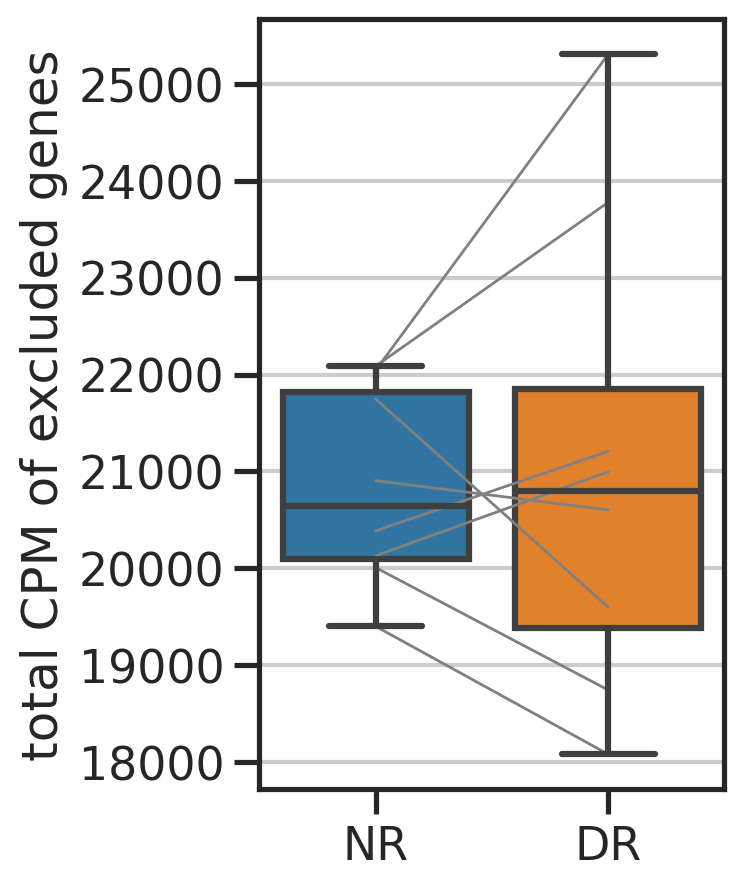

In [13]:
idx = np.arange(len(genes))[~expressed_any]
tensor_nr_ctrl = pbulks[0].T[idx]
tensor_dr_ctrl = pbulks[1].T[idx]

a = np.sum(np.power(10, tensor_nr_ctrl)-1, axis=0).ravel()
b = np.sum(np.power(10, tensor_dr_ctrl)-1, axis=0).ravel()

fig, ax = plt.subplots(figsize=(3,5))
for ai, bi in zip(a,b):
    ax.plot([0,1], [ai,bi], '-', color='gray', linewidth=1, markersize=1)
sns.boxplot([a,b], ax=ax)
ax.set_ylabel('total CPM of excluded genes')
ax.set_xticklabels(['NR', 'DR'])
plt.show()

# Do the tests

In [14]:
# test for each gene and cell type; 4 rep vs 4 rep - t-test and p-val correction 
ts, ps = ttest_ind(tensor_nr, tensor_dr, axis=2)
rs, qs, _, _ = multipletests(np.nan_to_num(ps, nan=1).reshape(-1,), method='fdr_bh')
rs = rs.reshape(ps.shape)
qs = qs.reshape(ps.shape)

# effect size
lfc = np.log2(10)*(np.mean(tensor_dr, axis=2) - np.mean(tensor_nr, axis=2)) # log2FC (log10CPM as raw counts)
# higherexp = np.maximum(np.mean(tensor_dr, axis=2), np.mean(tensor_nr, axis=2)) # mean exp for every gene type pair in the higher expressed condition

# why -- not expressed
i, j = np.where(np.isnan(ps))
np.isnan(ps).sum(), np.sum(tensor_nr[i,j]), np.sum(tensor_dr[i,j])

(0, 0.0, 0.0)

In [15]:
fc_threshold = 2
cond1   = rs # FDR< 0.05
cond2   = np.abs(lfc) >  np.log2(fc_threshold) 
cond2up = lfc         >  np.log2(fc_threshold) 
cond2dn = lfc         < -np.log2(fc_threshold) 

sde    = np.all([cond1, cond2],   axis=0)
sde_up = np.all([cond1, cond2up], axis=0)
sde_dn = np.all([cond1, cond2dn], axis=0)

sigsum = pd.DataFrame(index=unq_types)
sigsum['rej']   = np.sum(rs, axis=0)
sigsum['DE']    = np.sum(sde, axis=0)
sigsum['DR_up'] = np.sum(sde_up, axis=0)
sigsum['DR_dn'] = np.sum(sde_dn, axis=0)
sigsum

rej  DE  DR_up  DR_dn
L5PT_A   29   6      6      0
L5PT_B    1   0      0      0

In [16]:
res = pd.DataFrame()
gi_up, ti_up = sde_up.nonzero()
gi_dn, ti_dn = sde_dn.nonzero()
res['gene'] = genes_comm[np.hstack([gi_up, gi_dn])]
res['type'] = unq_types[np.hstack([ti_up, ti_dn])]
res['reason'] = ['DRup']*len(gi_up) + ['DRdn']*len(gi_dn)

# res.to_csv(os.path.join(outdir, 'DEGs_NRvsDR_P28P38_April11.csv'), header=True, index=False)
res

gene    type reason
0    Eprs  L5PT_A   DRup
1   Nr4a2  L5PT_A   DRup
2  Tiparp  L5PT_A   DRup
3   Nr4a3  L5PT_A   DRup
4   Fosl2  L5PT_A   DRup
5    Fosb  L5PT_A   DRup

In [17]:
res.groupby(['type', 'reason']).size().unstack().fillna(0).astype(int) #.value_counts()

reason  DRup
type        
L5PT_A     6

In [20]:
res.to_csv('/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/biorxiv/num_DRDEG_L5PTtypes.csv')

# show results

In [21]:
def show_onetype(idx, columns=["NR_1", "NR_2", "NR_3", "NR_4", 
                               "DR_1", "DR_2", "DR_3", "DR_4",
                              ]):
    """idx - cell type idx
    """
    gidx = np.logical_or(sde_up[:,idx], sde_dn[:,idx])
    _genes = genes_comm[gidx]

    p_nr = tensor_nr[gidx,:,:][:,idx,:]
    p_dr = tensor_dr[gidx,:,:][:,idx,:]
    
    
    ab = np.hstack([p_nr, p_dr])
    nr_mean = np.mean(p_nr, axis=1)
    ab = (ab - nr_mean.reshape(-1,1))*np.log2(10) # log2 FC w.r.t. the mean in NR
    ab = pd.DataFrame(ab, index=_genes, columns=columns)
    
    this_mlfc = (np.mean(p_nr, axis=1) - np.mean(p_dr, axis=1))*np.log2(10)
    this_ordr = np.argsort(this_mlfc)
    ab = ab.iloc[this_ordr]
    
    fig, ax = plt.subplots(figsize=(4, min(10, 0.3*len(ab))))
    sns.heatmap(ab, center=0, cmap='coolwarm', yticklabels=True, cbar_kws=dict(shrink=0.5, label='log2 FC (w.r.t. NR mean)'))
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.set_title(unq_types[idx])
    plt.show()

In [22]:
def show_volcano(thetypeidx, thetype, lfc, qs, cond1, cond2up, cond2dn, ax=None, bbox_to_anchor=(1,1), loc=None):
    """
    Gene by type matrices: 
        lfc matrix: log fold change
        qs matirx:
    
        cond1 : significant or not? 
        cond2up: FC above the cutoff?
        cond2dn: FC below the cutoff?
    
    thetypeidx: pick a type - one column index from the above matrices
    """
    eff = lfc[:,thetypeidx]
    pvl =  qs[:,thetypeidx]

    cnd_up = np.all([cond1[:,thetypeidx], 
                     cond2up[:,thetypeidx]], axis=0) 
    cnd_dn = np.all([cond1[:,thetypeidx], 
                     cond2dn[:,thetypeidx]], axis=0) 

    if ax is None:
        fig, ax = plt.subplots()
    else:
        pass
    ax.scatter(eff, -np.log10(pvl), s=1, color='gray')

    ax.scatter(eff[cnd_up], -np.log10(pvl)[cnd_up], s=5, #s=5, 
               label=f'DR up (n={cnd_up.sum():,})')
    ax.scatter(eff[cnd_dn], -np.log10(pvl)[cnd_dn], s=5, #s=5, 
               label=f'DR dn (n={cnd_dn.sum():,})')

    ax.set_xlabel('log2(FC) (DR/NR in CPM)')
    ax.set_ylabel('-log10(FDR)')
    ax.set_title(f'{thetype}')
    ax.legend(bbox_to_anchor=bbox_to_anchor, loc=loc)
    return ax

In [23]:
types_order = [
    'L6CT_A', 
    'L6CT_B', 
    'L6CT_C', 
]
len(types_order)

3

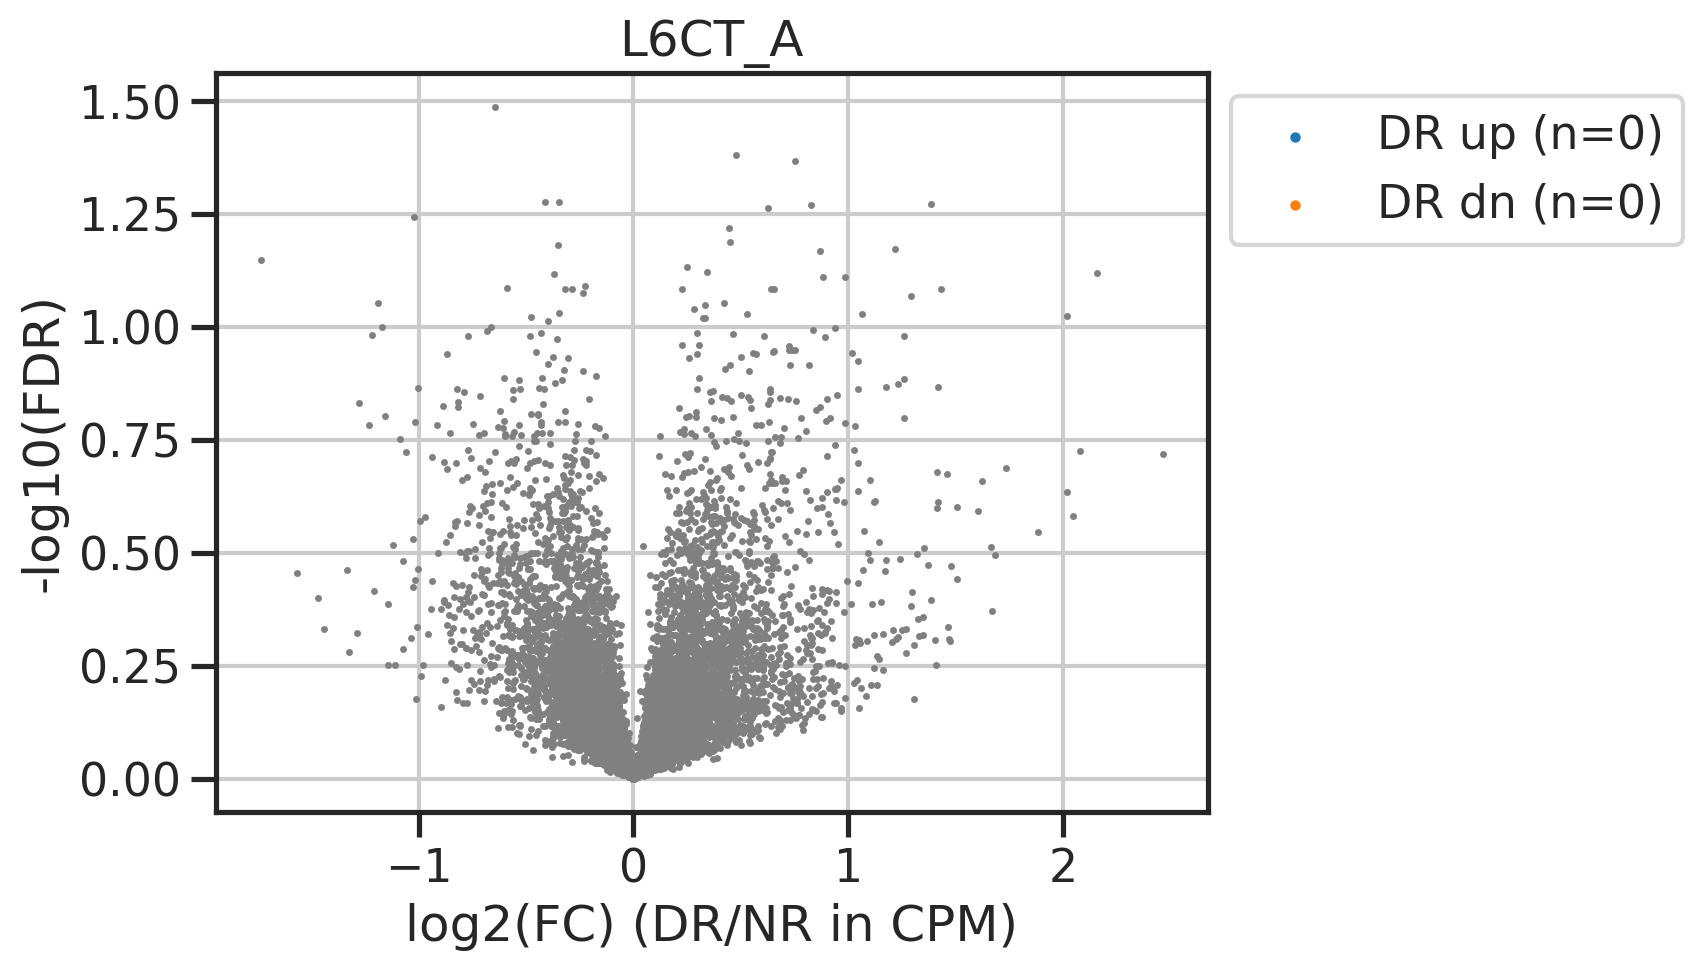

In [24]:
thetype = 'L6CT_A'
thetypeidx = basicu.get_index_from_array(unq_types, [thetype])[0]
assert thetypeidx != -1
show_volcano(thetypeidx, thetype, lfc, qs, cond1, cond2up, cond2dn) 
plt.show()

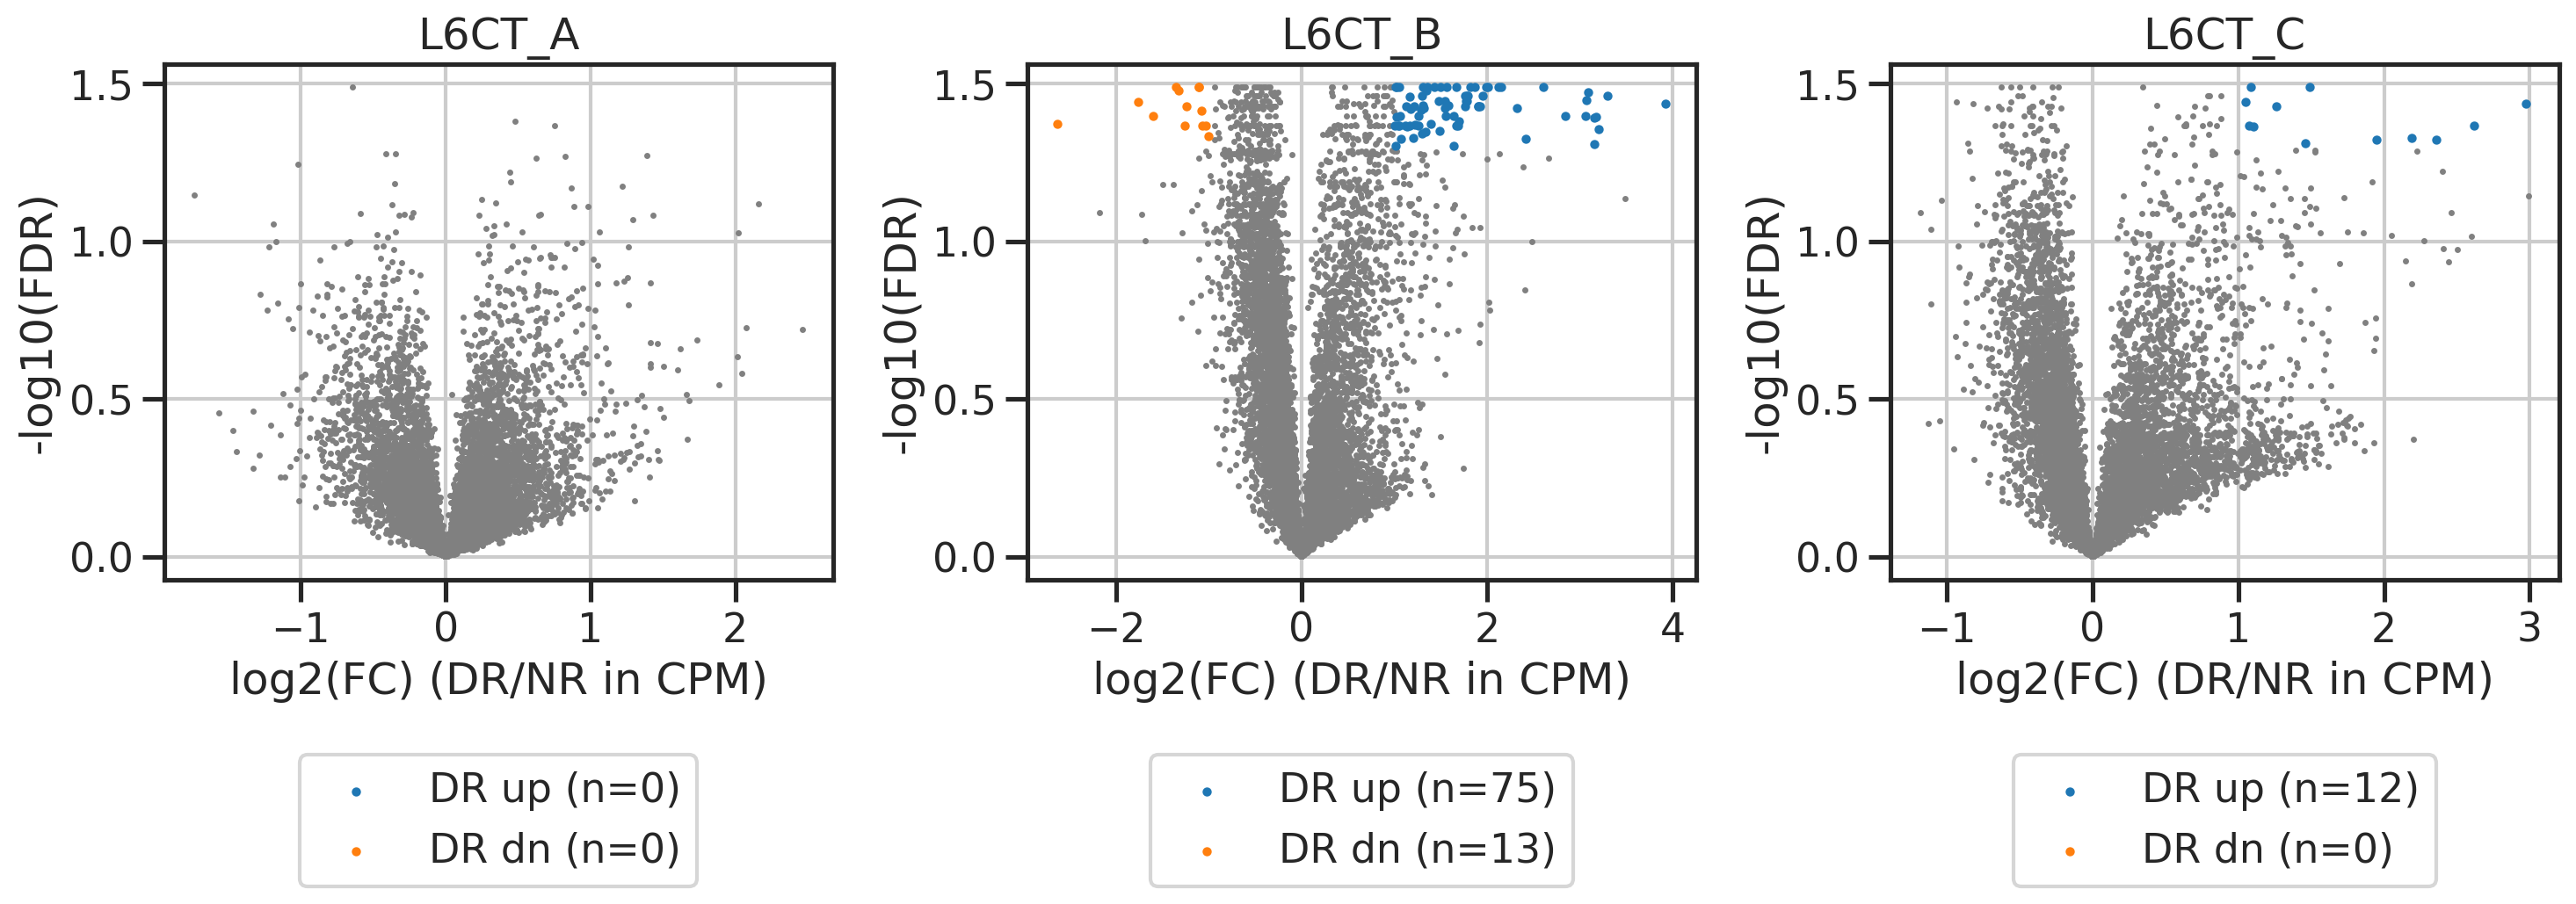

In [25]:
fig, axs = plt.subplots(1,3,figsize=(5*3,6*1))
for thetypeidx, thetype in enumerate(unq_types):
    assert thetypeidx != -1
    ax = axs.flat[thetypeidx]
    show_volcano(thetypeidx, thetype, lfc, qs, cond1, cond2up, cond2dn, ax=ax, bbox_to_anchor=(0.5, -0.3), loc='upper center') 
fig.tight_layout()
plt.show()

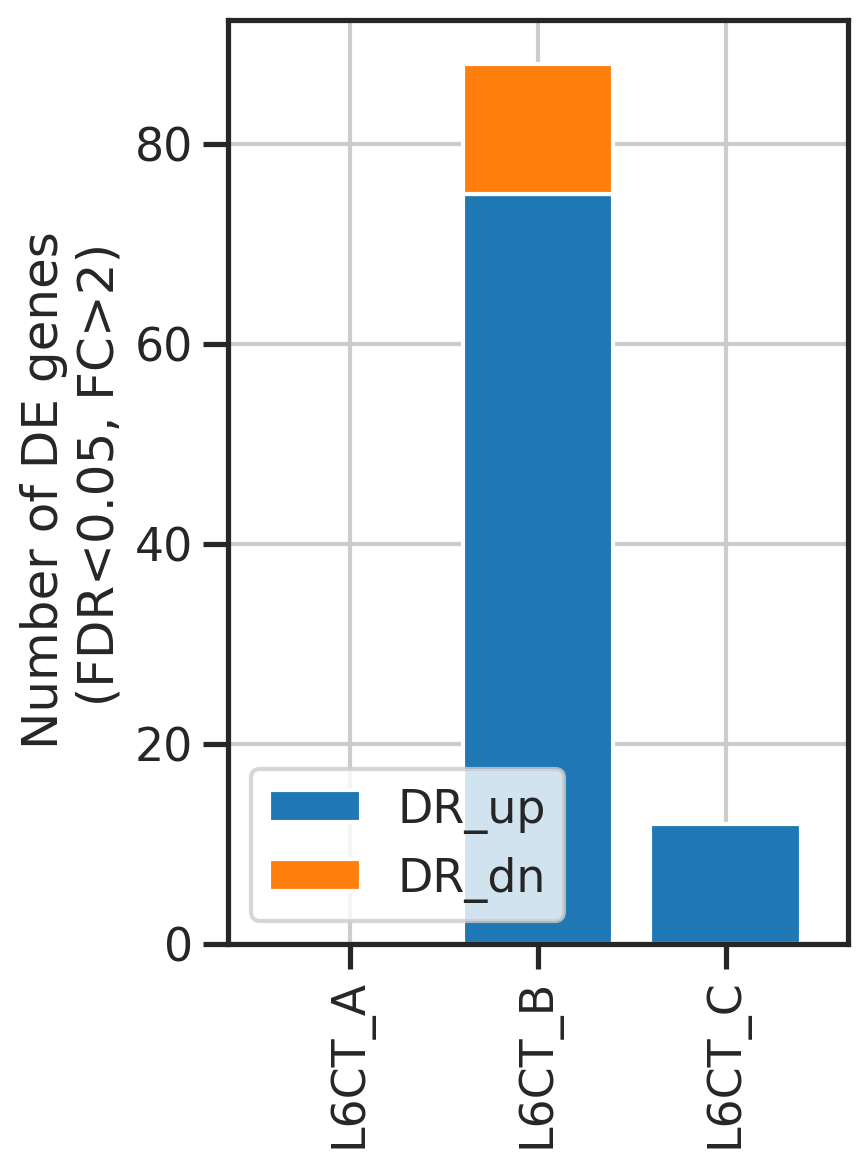

In [26]:
fig, ax = plt.subplots(figsize=(4,6))
sigsum.loc[types_order][['DR_up', 'DR_dn']].plot.bar(stacked=True, width=0.8, ax=ax)
ax.set_ylabel('Number of DE genes \n (FDR<0.05, FC>2)')
plt.show()

# Barplot - side-by-side with L2/3 IT

In [19]:
res_l23 = pd.read_csv('/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/biorxiv/num_DRDEG_L23types.csv')
res_l6ct = pd.read_csv('/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/biorxiv/num_DRDEG_L6CTtypes.csv')
res_l6it = pd.read_csv('/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/biorxiv/num_DRDEG_L6ITtypes.csv')
a = res_l23.groupby(['type', 'reason']).size().unstack()
b = res_l6ct.groupby(['type', 'reason']).size().unstack().reindex(['L6CT_A','L6CT_B','L6CT_C'])
c = res_l6ct.groupby(['type', 'reason']).size().unstack().reindex(['L6IT_A','L6IT_B'])
a

reason  DRdn  DRup
type              
L2/3_A    10    60
L2/3_B   207   184
L2/3_C    79   226

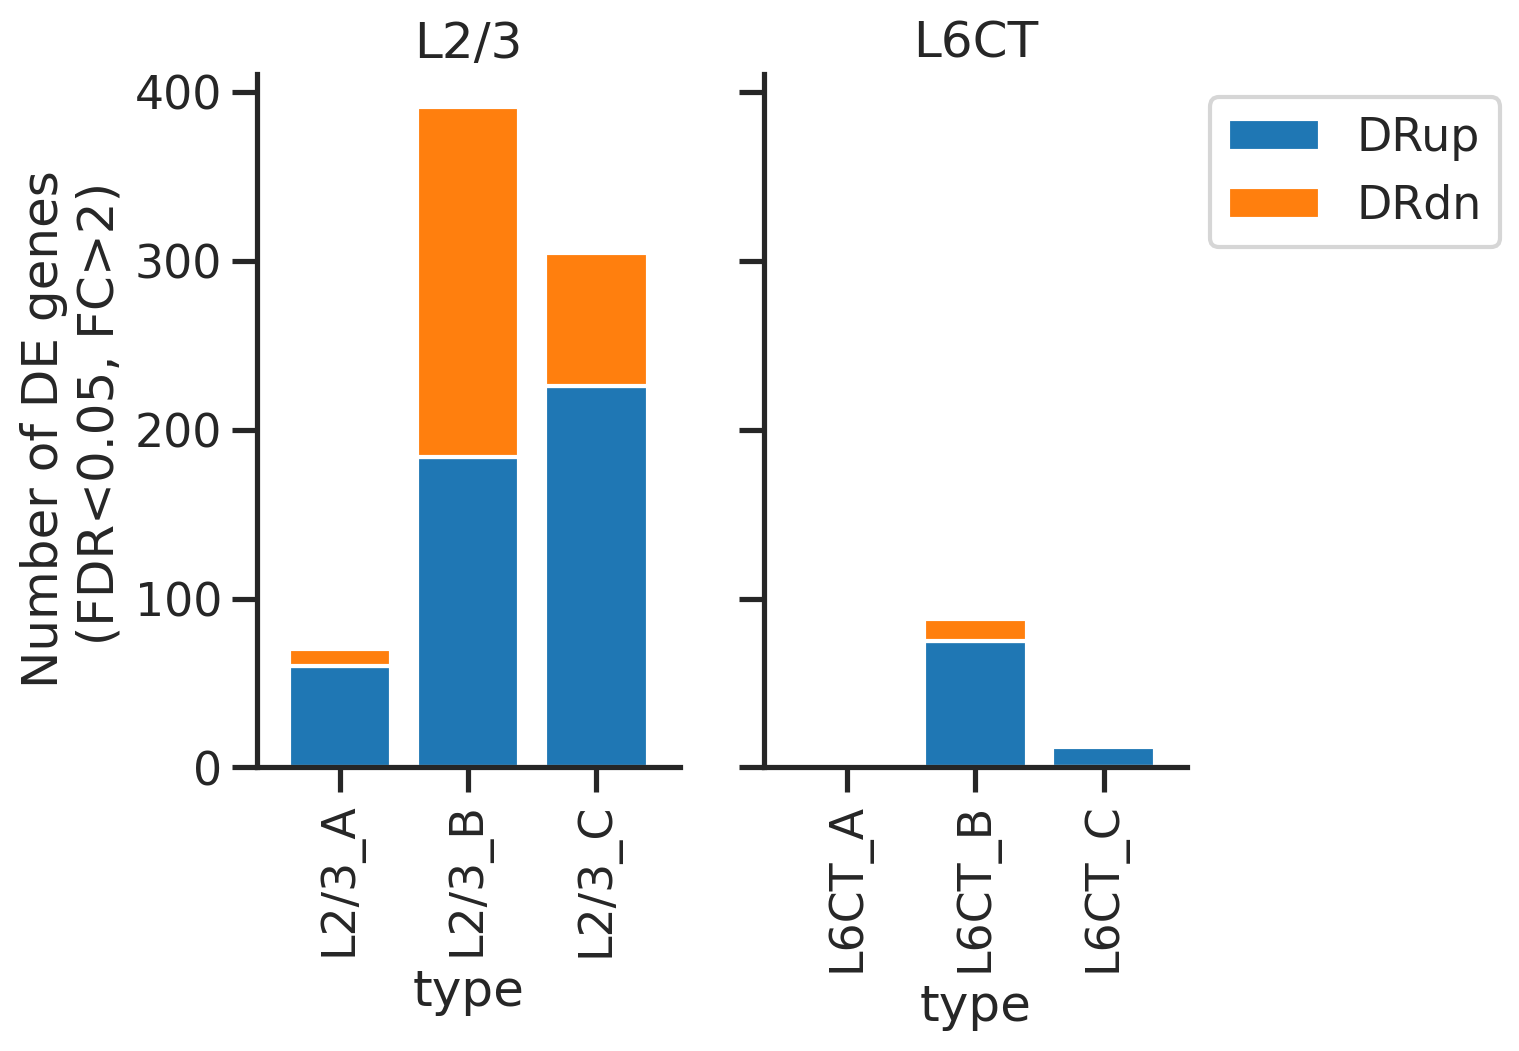

In [71]:
fig, axs = plt.subplots(1,2,figsize=(3*2,4.5), sharey=True)
ax = axs[0]
a[['DRup', 'DRdn']].plot.bar(stacked=True, width=0.8, ax=ax, legend=False)
sns.despine(ax=ax)
ax.set_ylabel('Number of DE genes \n (FDR<0.05, FC>2)')
ax.grid(False)
ax.set_title('L2/3')

ax = axs[1]
b[['DRup', 'DRdn']].plot.bar(stacked=True, width=0.8, ax=ax)
sns.despine(ax=ax)
ax.legend(bbox_to_anchor=(1,1), loc='upper left')
ax.grid(False)
ax.set_title('L6CT')

ax = axs[2]
c[['DRup', 'DRdn']].plot.bar(stacked=True, width=0.8, ax=ax)
sns.despine(ax=ax)
ax.legend(bbox_to_anchor=(1,1), loc='upper left')
ax.grid(False)
ax.set_title('L6i')

plt.show()

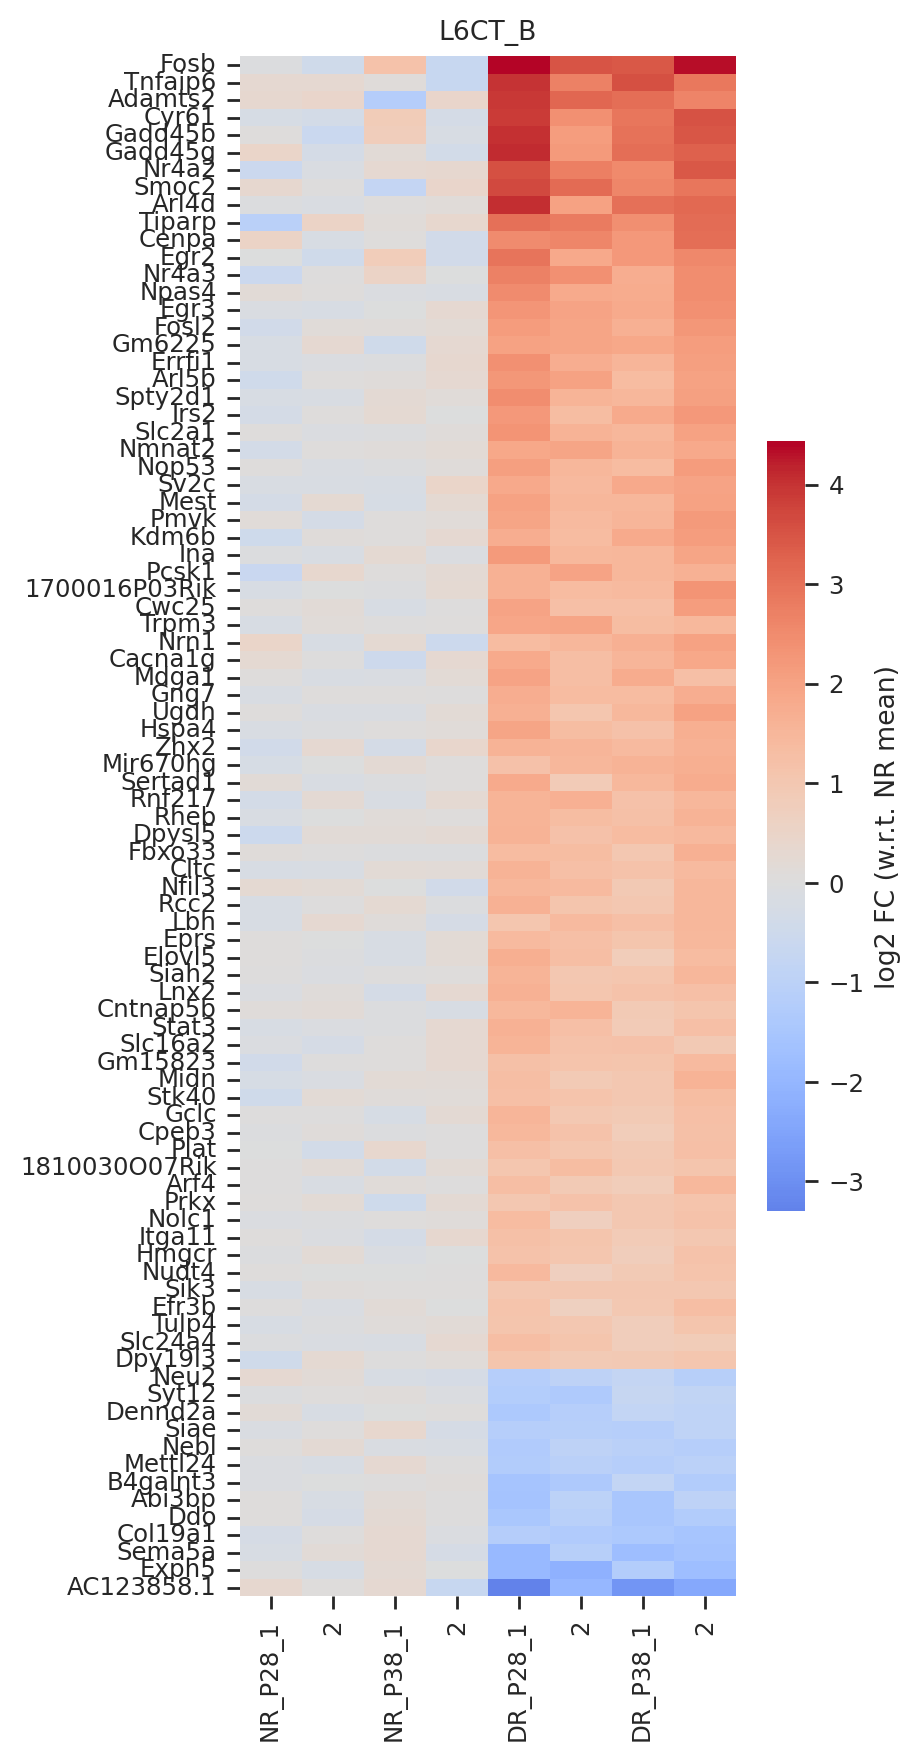

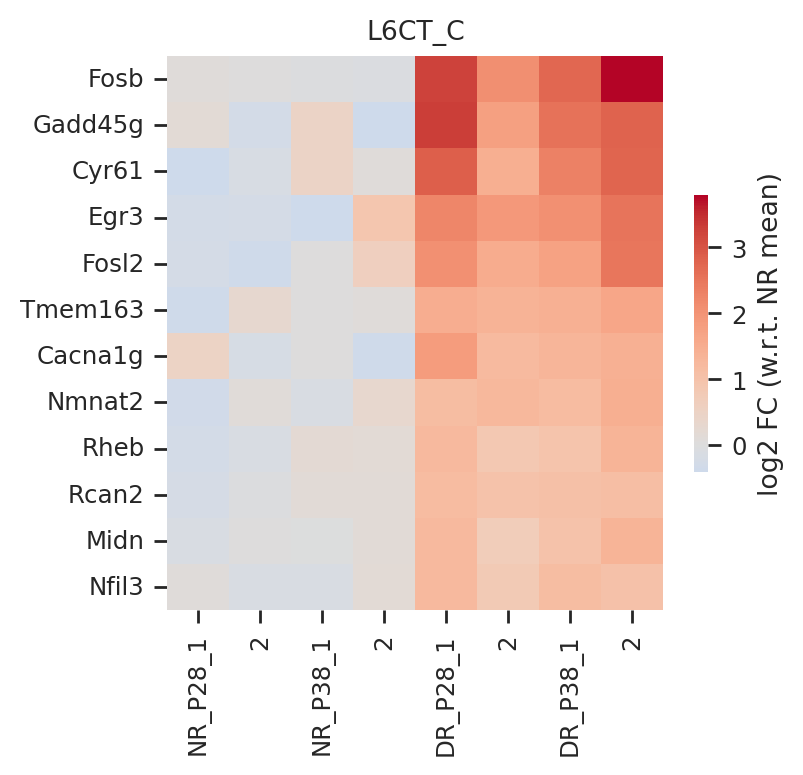

In [29]:
columns = [
    'NR_P28_1', '2', 'NR_P38_1', '2',
    'DR_P28_1', '2', 'DR_P38_1', '2',
]
with sns.plotting_context('paper'):
    for i, (_type, row) in enumerate(sigsum.iterrows()):
        if row['DE'] > 0:
            show_onetype(i, columns=columns)

# Check a few genes and see

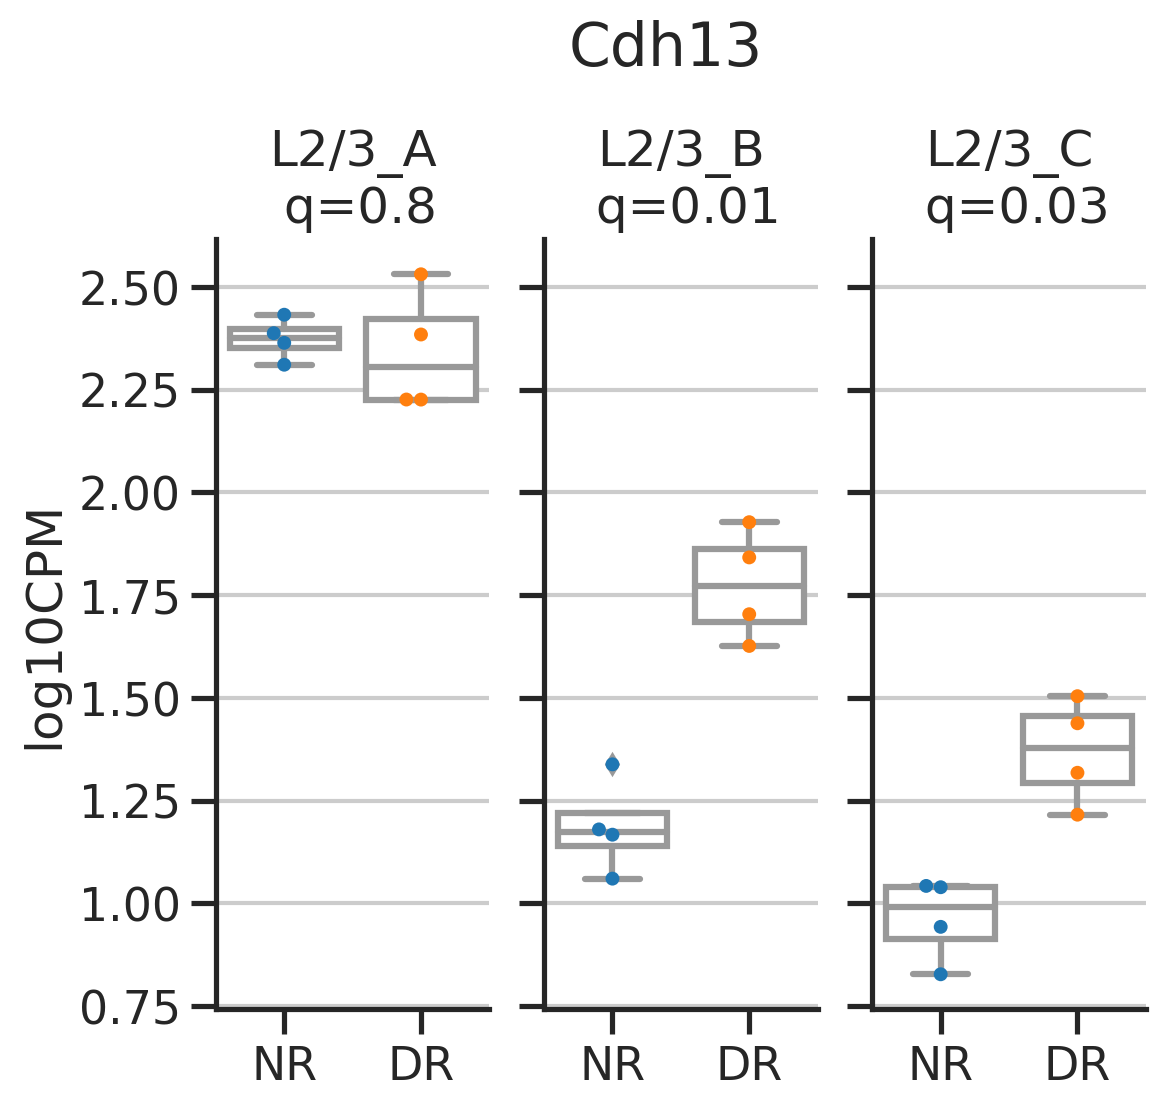

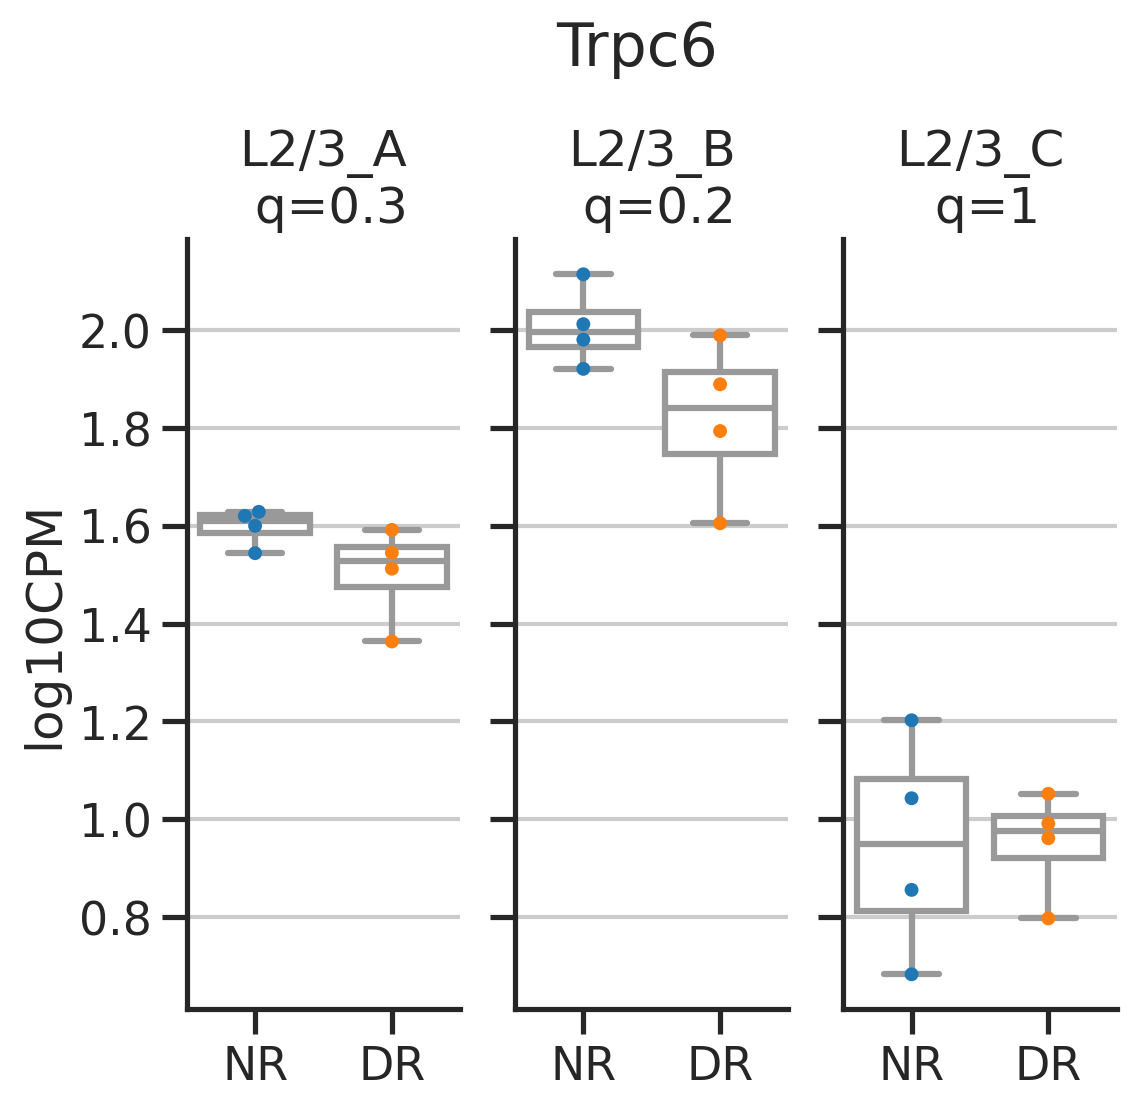

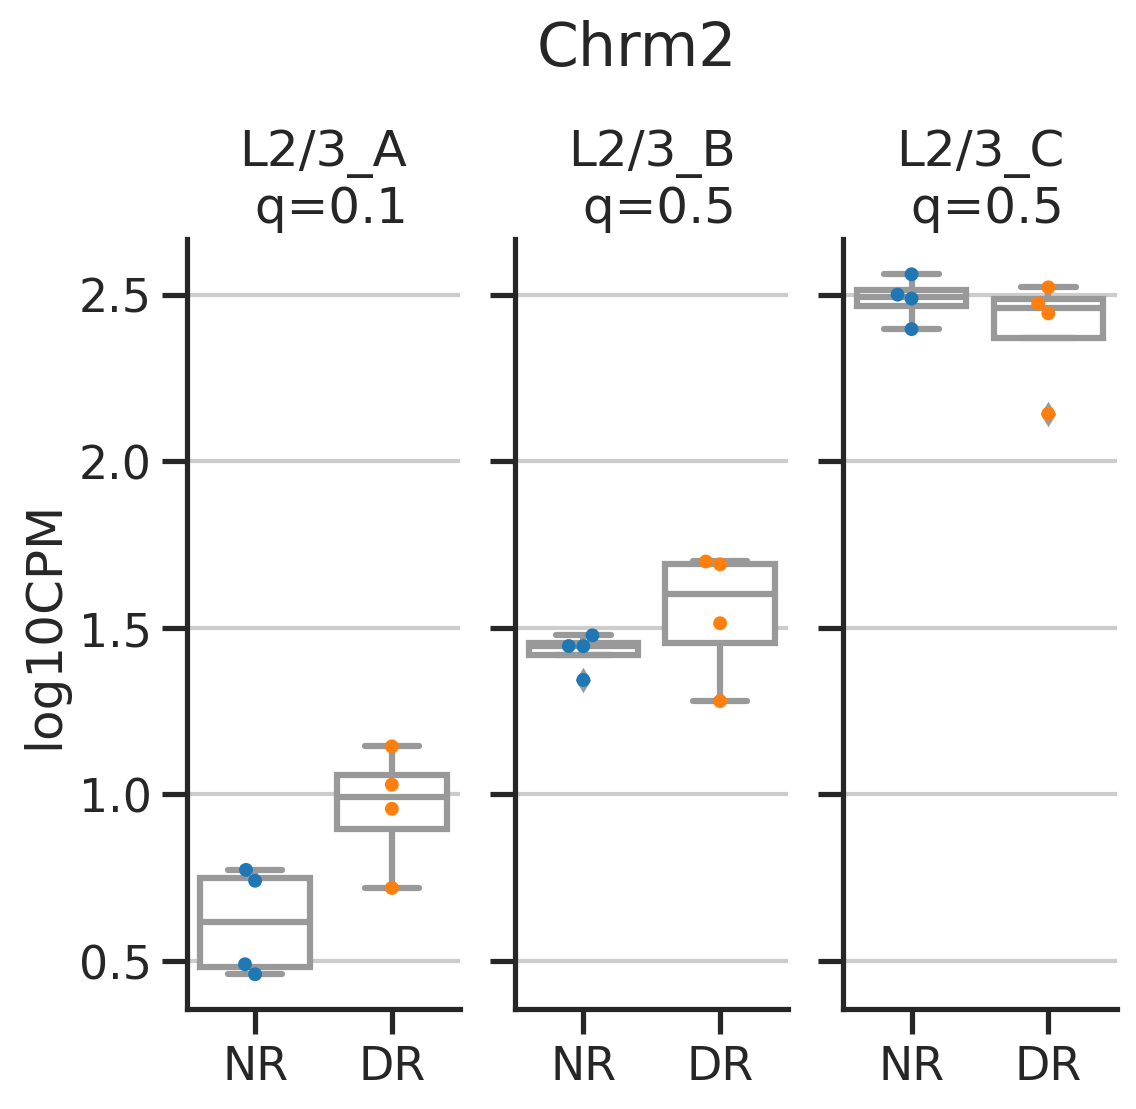

In [28]:
for gene_name in ['Cdh13', 'Trpc6', 'Chrm2']: #['Col19a1', 'Nr4a2', 'Fosb']:
    fig, axs = plt.subplots(1,3,figsize=(2*3,5), sharey=True)
    fig.suptitle(gene_name, y=1.1)
    for type_name, ax in zip(['L2/3_A', 'L2/3_B', 'L2/3_C'], axs):
        gidx = basicu.get_index_from_array(genes, [gene_name])[0]
        gidx2 = basicu.get_index_from_array(genes_comm, [gene_name])[0]
        cidx = basicu.get_index_from_array(unq_types, [type_name])[0]
        p_nr, p_dr = pbulks[:,:,:,gidx][:,:,cidx]
        assert gidx != -1
        assert cidx != -1

        sns.boxplot  ([p_nr, p_dr], color='white', ax=ax)
        sns.swarmplot([p_nr, p_dr], s=5, ax=ax)

        # check
        # l2fc2 = np.log2(10)*(np.mean(p_dr) - np.mean(p_nr))
        eff = lfc[gidx2, cidx]
        q   = qs[gidx2, cidx]
        sns.despine(ax=ax)

        ax.set_xticklabels(['NR', 'DR'])
        ax.set_ylabel('log10CPM')
        ax.set_title(f'{type_name}\n q={q:.1g}')
    plt.show()

# a plot of those unique genes across all cell types

In [29]:
from scipy.stats import zscore

In [30]:
degs = np.unique(res['gene'])
degs_idx = basicu.get_index_from_array(genes, degs)

In [31]:
a = pbulks[:,:,:,degs_idx].T
a = np.swapaxes(a,2,3)
a0,a1,a2,a3 = a.shape # gene, type, cond, rep
am = zscore(np.mean(a, axis=(2,3)), axis=1)
af = zscore(a.reshape(a0, a1*a2*a3), axis=1)

rowidx = np.array(basicu.order_by_hc(af))
colidx = np.array(basicu.order_by_hc(am.T))
# colidx = basicu.get_index_from_array(xclsts_sel, types_order)
colidx_expanded = np.ravel(a2*a3*colidx.reshape(-1,1) + np.repeat(np.arange(a2*a3).reshape(1,-1), len(colidx), axis=0))

In [32]:
a.shape

(525, 3, 2, 4)

In [33]:
nr_mean = np.mean(a, axis=3)[:,:,0]
a_lfc = np.log2(10)*(a-nr_mean.reshape(a0,a1,1,1))
af_lfc = a_lfc.reshape(a0, a1*a2*a3)

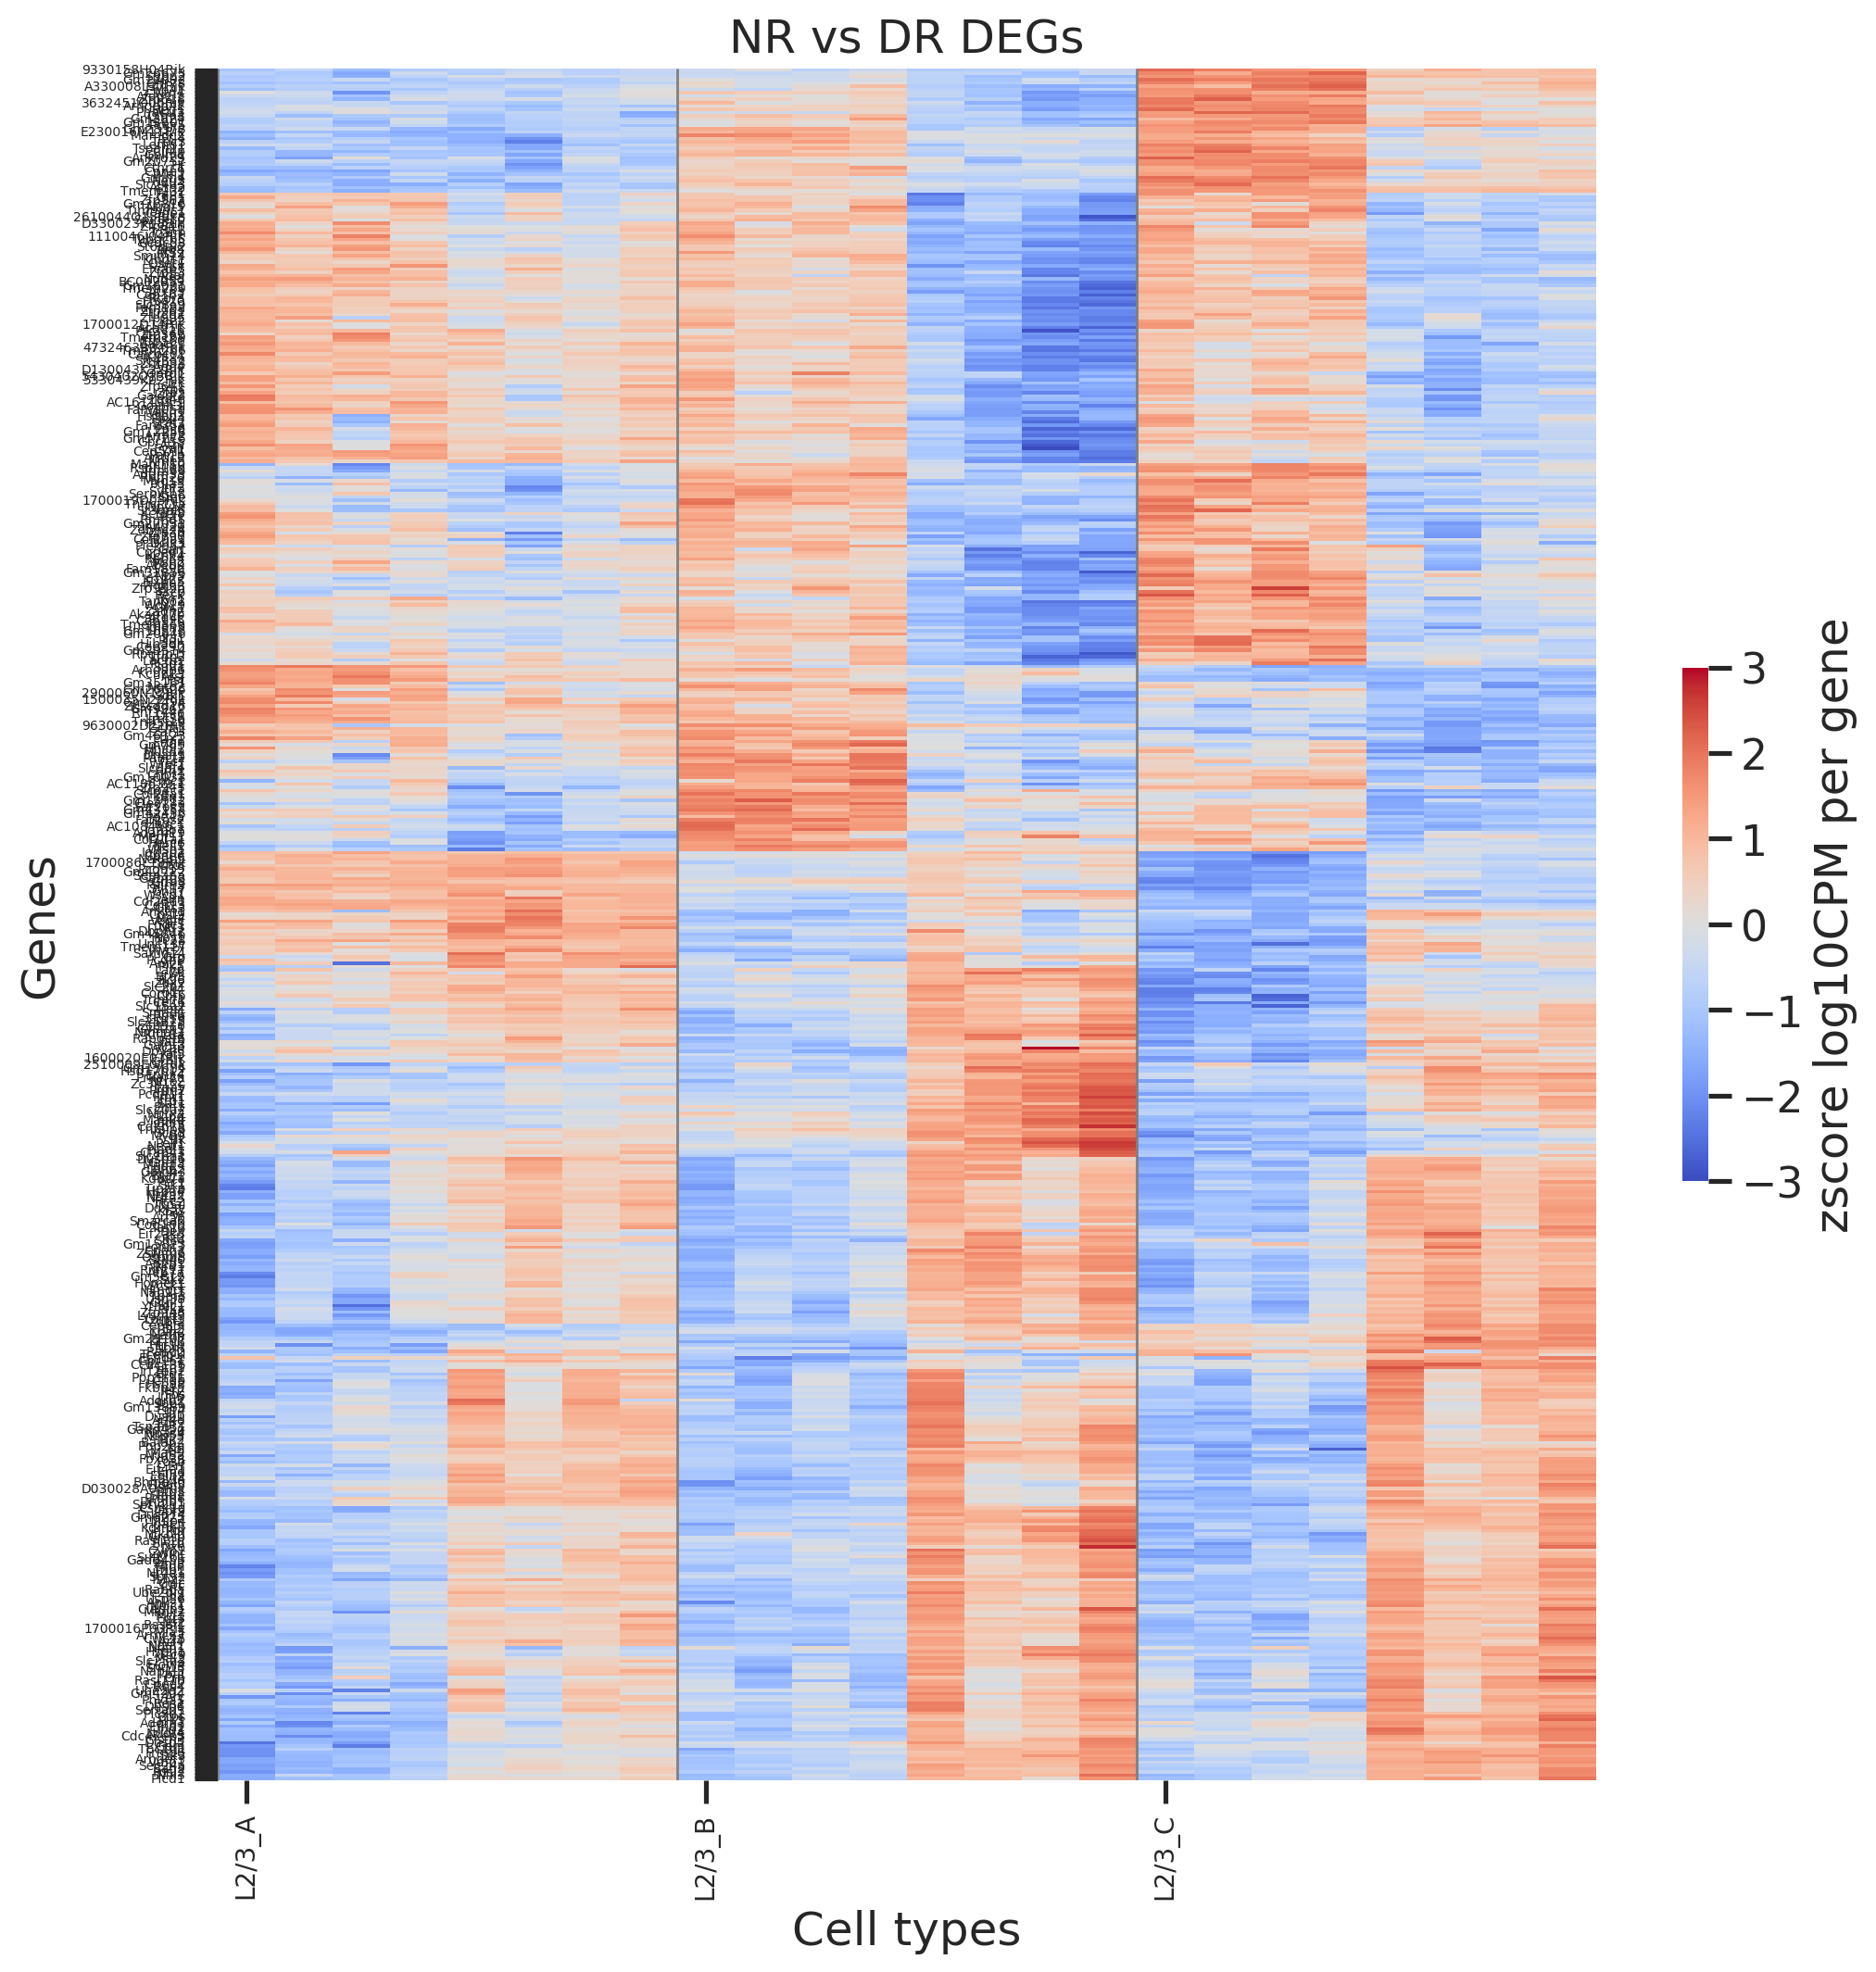

In [34]:
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(af[rowidx][:,colidx_expanded], 
            yticklabels=True, # 20, #degs[rowidx],
            xticklabels=a2*a3,
            cbar_kws=dict(shrink=0.3, label='zscore log10CPM per gene'),
            cmap='coolwarm', 
            center=0, vmin=-3, vmax=3,
            ax=ax) 
ax.vlines(np.arange(0, a1*a2*a3, a2*a3), 0, a0, color='gray', linewidth=1)
ax.set_xticklabels(unq_types[colidx], rotation=90, fontsize=10)
ax.set_yticklabels(degs[rowidx], rotation=0, fontsize=5)
ax.set_ylabel('Genes')
ax.set_xlabel('Cell types')
ax.set_title('NR vs DR DEGs')
plt.show()

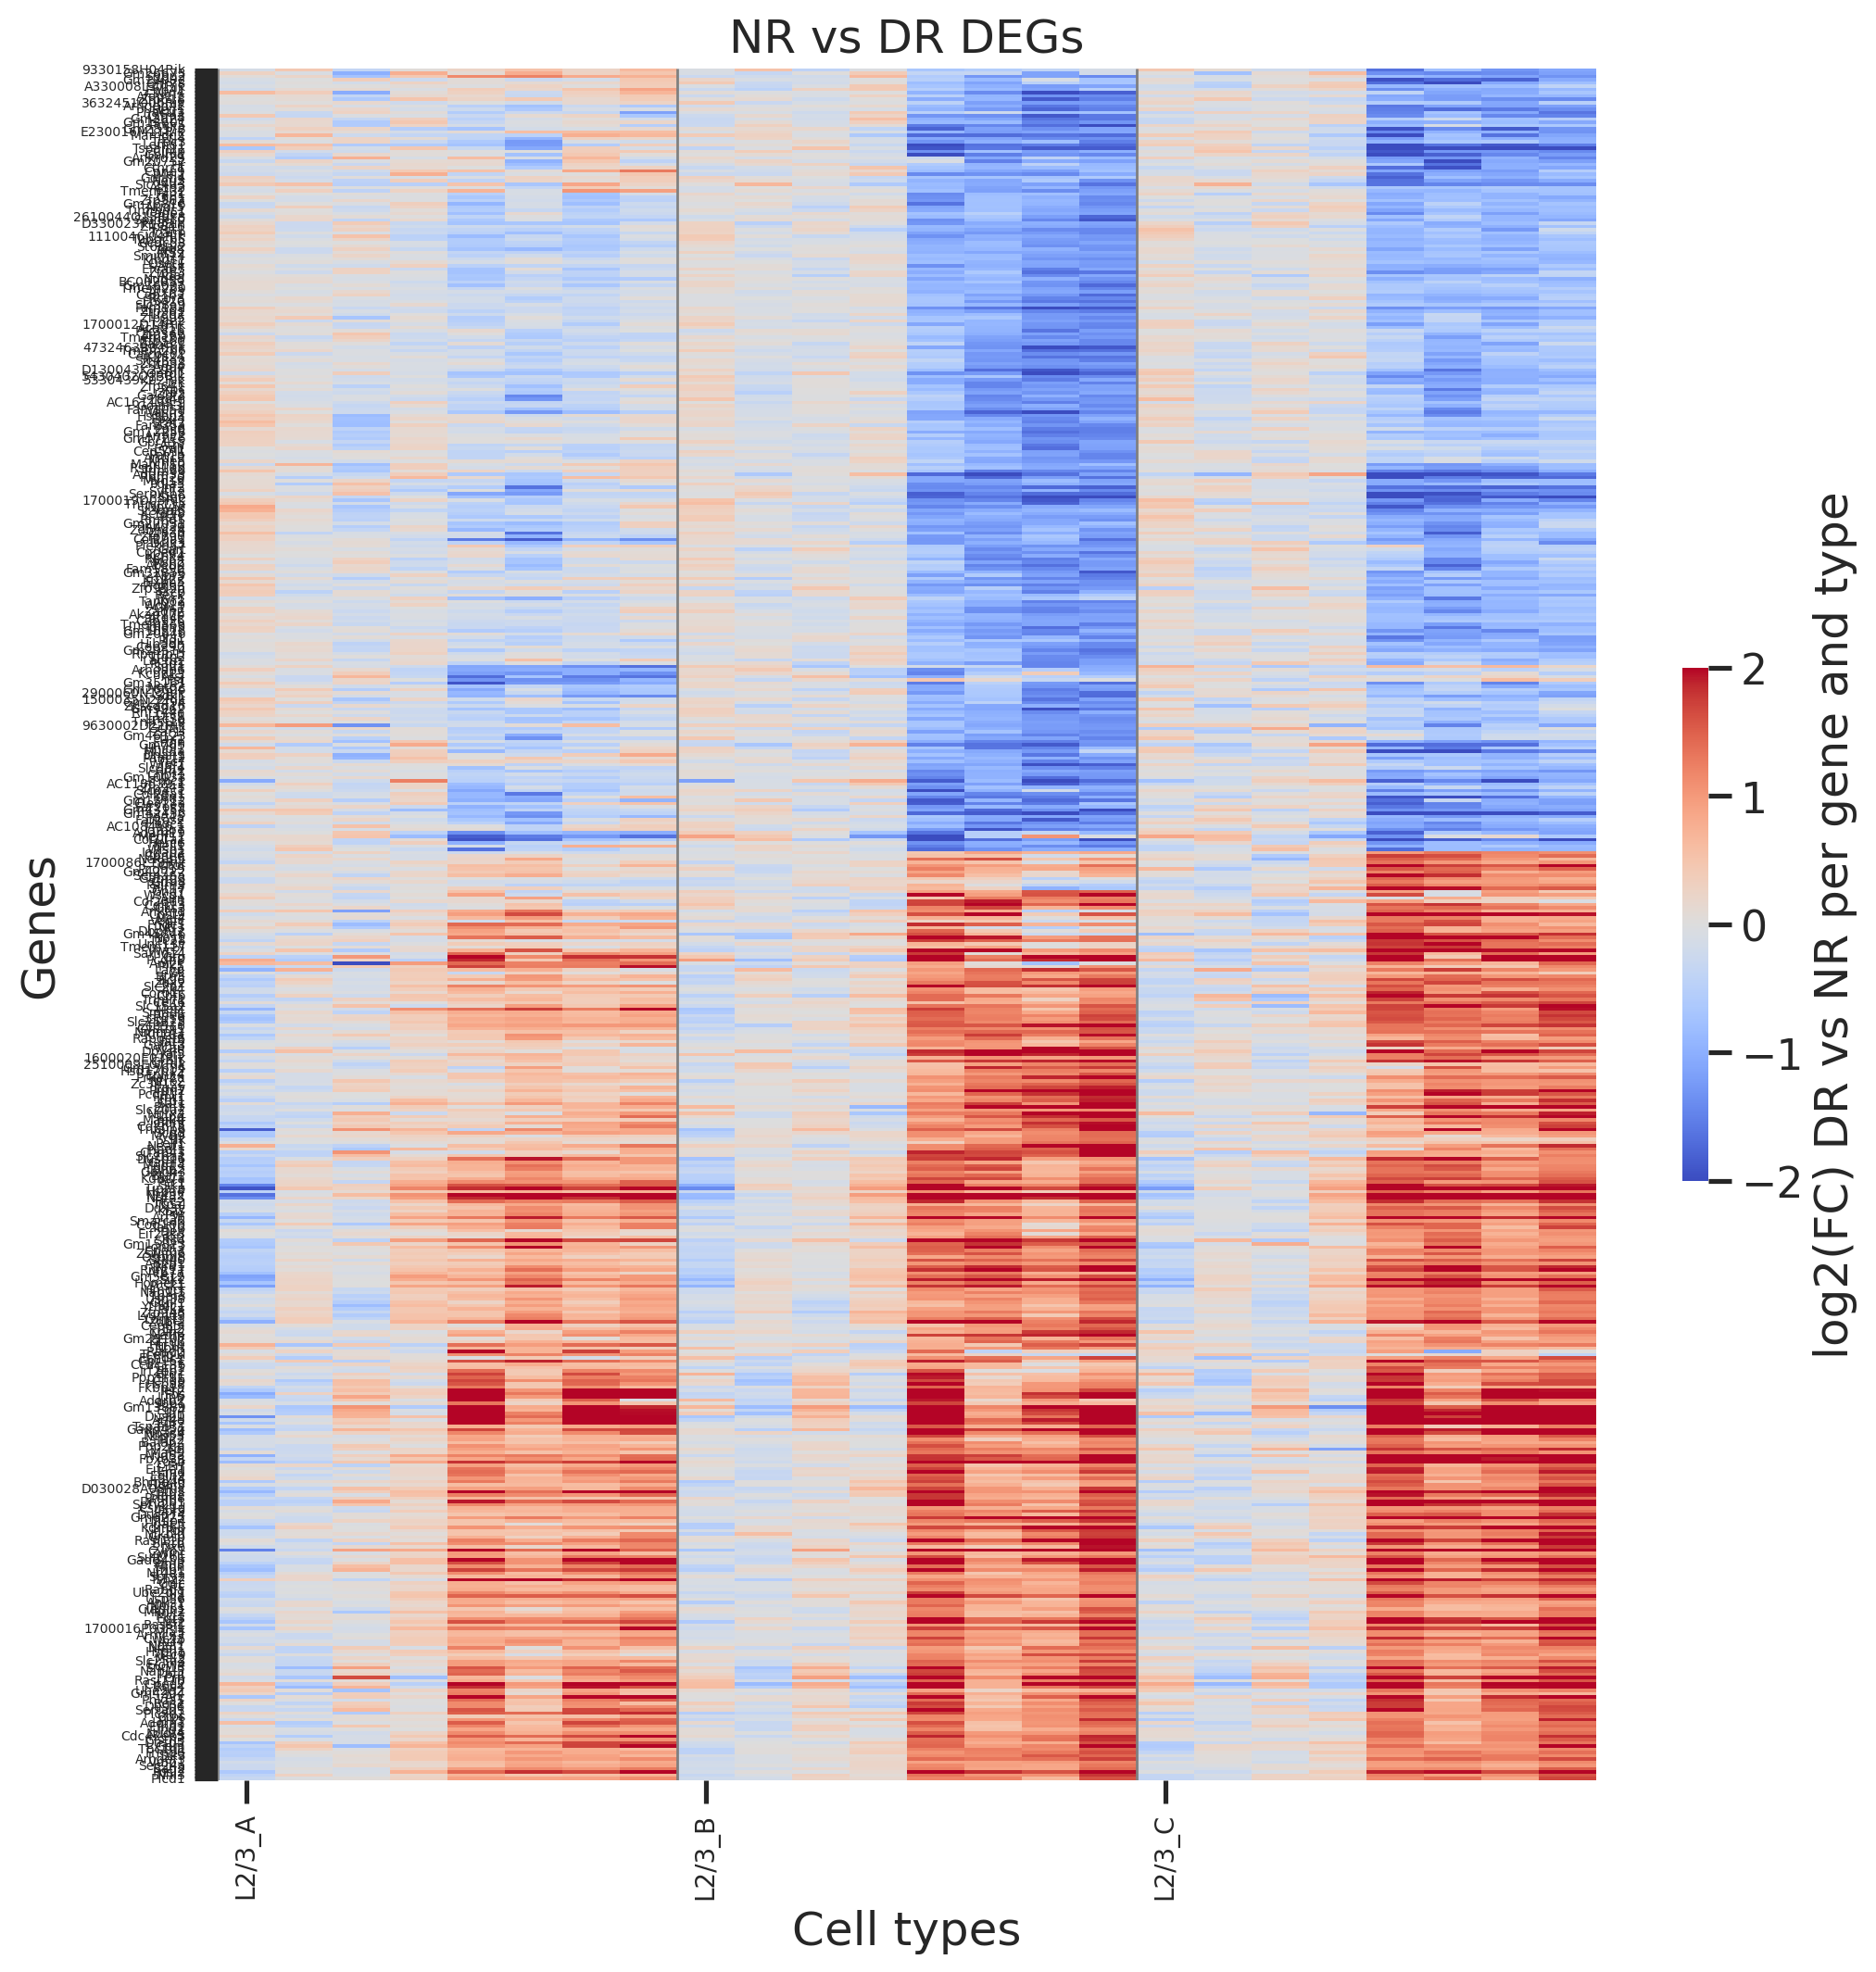

In [35]:
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(af_lfc[rowidx][:,colidx_expanded], 
            yticklabels=True, # 20, #degs[rowidx],
            xticklabels=a2*a3,
            cbar_kws=dict(shrink=0.3, label='log2(FC) DR vs NR per gene and type'),
            cmap='coolwarm', 
            center=0, vmin=-2, vmax=2,
            ax=ax) 
ax.vlines(np.arange(0, a1*a2*a3, a2*a3), 0, a0, color='gray', linewidth=1)
ax.set_xticklabels(unq_types[colidx], rotation=90, fontsize=10)
ax.set_yticklabels(degs[rowidx], rotation=0, fontsize=5)
ax.set_ylabel('Genes')
ax.set_xlabel('Cell types')
ax.set_title('NR vs DR DEGs')
plt.show()

# overlap with type genes

In [36]:
def num_up(reasons):
    return np.sum(reasons == 'DRup')

def num_dn(reasons):
    return np.sum(reasons == 'DRdn')
    
def overall(reasons):
    a = num_up(reasons)
    b = num_dn(reasons)
    
    if a == 0 and b > 0:
        return 'DR_dn'
    elif b == 0 and a > 0:
        return 'DR_up'
    elif a > 0 and b > 0:
        return 'DR_updn'

resflat = res.groupby('gene').agg({'reason': (num_up, num_dn, overall)})['reason'] #  'reason': get_num_dn})
resflat

num_up  num_dn overall
gene                                 
1110046J04Rik       0       1   DR_dn
1500035N22Rik       0       1   DR_dn
1600020E01Rik       1       0   DR_up
1700012D14Rik       0       1   DR_dn
1700016P03Rik       3       0   DR_up
...               ...     ...     ...
Zfp995              0       1   DR_dn
Zhx2                2       0   DR_up
Zkscan16            0       1   DR_dn
Zswim6              2       0   DR_up
Zwint               1       0   DR_up

[525 rows x 3 columns]

In [37]:
#
cond_overlap1 = (
         (resflat['num_up'] != 0) & 
         (resflat['num_dn'] != 0)
       )
cond_overlap2 = (
         (resflat['num_up'] != 0) & 
         (resflat['num_dn'] == 0)
       )
cond_overlap3 = (
         (resflat['num_up'] == 0) & 
         (resflat['num_dn'] != 0)
       )

# resflat[cond_overlap1]
print("up and down", cond_overlap1.sum())
print("up only", cond_overlap2.sum())
print("down only", cond_overlap3.sum())

up and down 0
up only 285
down only 240


In [38]:
# f = '/data/qlyu/v1/data/cheng21_cell_scrna/res/L23-ABC-genes-n288-n286unq-annot.csv'
# fout = '/data/qlyu/v1/data/cheng21_cell_scrna/res/L23-ABC-genes-n288-n286unq-annot_v2.csv'

# df2 = pd.read_csv(f)
# df2['DR_DE'] = df2['gene'].apply(lambda x: x in degs) 
# df2 = pd.merge(df2, resflat['overall'].rename('DR_updn'), left_on='gene', right_index=True, how='left')
# df2.to_csv(fout, header=True, index=False)
# df2

In [39]:
f = '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/cheng21_cell_scrna/res/L23-ABC-genes-n288-n286unq-annot_v2.csv'
df2 = pd.read_csv(f)
df2

gene group  ispicked P17on     P14      DR  DR_DE DR_updn
0            Matn2    A2      True     A      BC       1  False     NaN
1          Fam126a    A2     False     A  unsure       1  False     NaN
2           Egfem1    A2      True     A  unsure  unsure  False     NaN
3          Gm19410    A2     False     A  unsure       1  False     NaN
4             Grk3    A2     False     A  unsure       1  False     NaN
..             ...   ...       ...   ...     ...     ...    ...     ...
281         Brinp3    C3      True     C      BC  unsure  False     NaN
282           Ell2    C3      True     C  unsure       3   True   DR_up
283        Gm21949    C3     False     C  unsure  unsure  False     NaN
284           Jdp2    C3      True     C      BC       3  False     NaN
285  3632451O06Rik    C3     False     C  unsure  unsure   True   DR_dn

[286 rows x 8 columns]

In [40]:
typegenes = df2['gene'].values
degs_up = resflat[resflat['overall']=='DR_up'].index.values
degs_dn = resflat[resflat['overall']=='DR_dn'].index.values

detgs = np.intersect1d(degs, typegenes)
detgs_up = np.intersect1d(degs_up, typegenes)
detgs_dn = np.intersect1d(degs_dn, typegenes)
print(degs.shape, typegenes.shape, detgs.shape)
print(detgs.shape, detgs_up.shape, detgs_dn.shape)
detgs, detgs_up, detgs_dn

(525,) (286,) (55,)
(55,) (28,) (27,)


(array(['1700086L19Rik', '3632451O06Rik', 'Afap1l1', 'Airn', 'Arhgap42',
        'Astn2', 'Bdnf', 'Cbln2', 'Cdh13', 'Clmp', 'Col11a1', 'Col23a1',
        'Col26a1', 'Cpne6', 'Cpne9', 'Ell2', 'Epb41', 'Etl4', 'Gabrg3',
        'Glis3', 'Gm42722', 'Golim4', 'Grm8', 'Heg1', 'Hkdc1', 'Igfn1',
        'Iqgap2', 'Kcnk13', 'Kctd8', 'Lemd1', 'Mei1', 'Myh9', 'Nckap5',
        'Nefm', 'Nell1', 'Neu2', 'Npas4', 'Npr3', 'Nptx2', 'Ntn4', 'Olfm3',
        'Otof', 'Palm2', 'Pcdh19', 'Pcsk5', 'Scg3', 'Sema6a', 'Sgpp2',
        'Slc24a3', 'Syt17', 'Tmem117', 'Tmem232', 'Ttc28', 'Vwc2l',
        'Zfp618'], dtype=object),
 array(['1700086L19Rik', 'Airn', 'Bdnf', 'Cbln2', 'Cdh13', 'Col23a1',
        'Cpne6', 'Ell2', 'Gabrg3', 'Glis3', 'Gm42722', 'Grm8', 'Iqgap2',
        'Kctd8', 'Myh9', 'Nckap5', 'Nefm', 'Npas4', 'Nptx2', 'Otof',
        'Palm2', 'Pcdh19', 'Scg3', 'Sema6a', 'Syt17', 'Tmem117', 'Ttc28',
        'Vwc2l'], dtype=object),
 array(['3632451O06Rik', 'Afap1l1', 'Arhgap42', 'Astn2', 'Clmp', 'Col1

In [41]:
dfplot = pd.merge(resflat['overall'].rename('DR'), df2.set_index('gene')['P17on'].rename('type'), 
                  left_index=True, right_index=True, how='outer')
dfplot['isType']= ~pd.isna(dfplot['type'])
dfplot['isDR']  = ~pd.isna(dfplot['DR'])
dfplot['DR_up'] = dfplot['DR'].apply(lambda x: x == 'DR_up') 
dfplot['DR_dn'] = dfplot['DR'].apply(lambda x: x == 'DR_dn') 
dfplot

DR type  isType   isDR  DR_up  DR_dn
gene                                                  
1110046J04Rik  DR_dn  NaN   False   True  False   True
1500035N22Rik  DR_dn  NaN   False   True  False   True
1600020E01Rik  DR_up  NaN   False   True   True  False
1700012D14Rik  DR_dn  NaN   False   True  False   True
1700016P03Rik  DR_up  NaN   False   True   True  False
...              ...  ...     ...    ...    ...    ...
Zhx2           DR_up  NaN   False   True   True  False
Zkscan16       DR_dn  NaN   False   True  False   True
Zmat4            NaN    C    True  False  False  False
Zswim6         DR_up  NaN   False   True   True  False
Zwint          DR_up  NaN   False   True   True  False

[756 rows x 6 columns]

In [42]:
# from matplotlib_venn import venn2
# from matplotlib_venn import venn3

# # set_list = [
# #     set(typegenes.tolist()), 
# #     set(degs.tolist()),
# # ]
# # fig, ax = plt.subplots()
# # venn2(set_list, set_labels=('L2/3 type genes', 'DR DE genes'), ax=ax)
# # plt.show()

# set_list = [
#     set(typegenes.tolist()), 
#     set(degs_up.tolist()),
#     set(degs_dn.tolist()),
# ]
# fig, ax = plt.subplots()
# venn3(set_list, set_labels=('L2/3 type genes', 'DR up genes', 'DR dn'), ax=ax)
# plt.show()

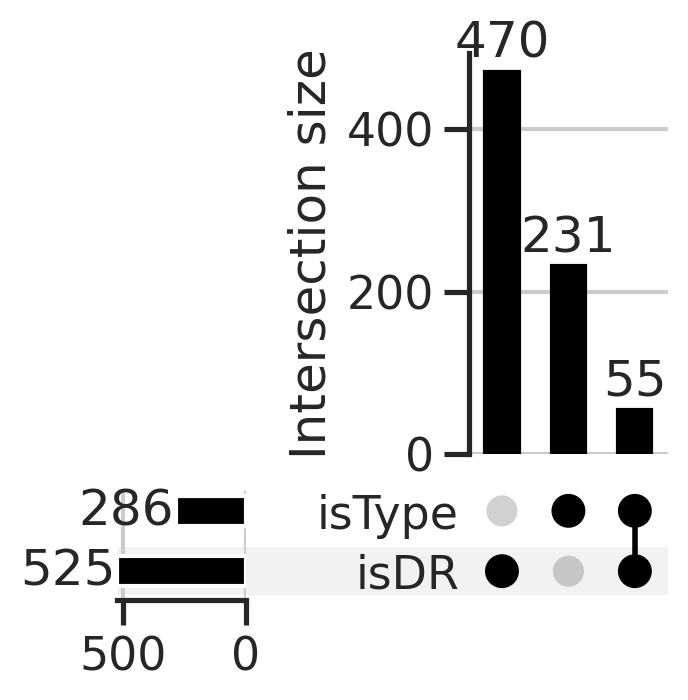

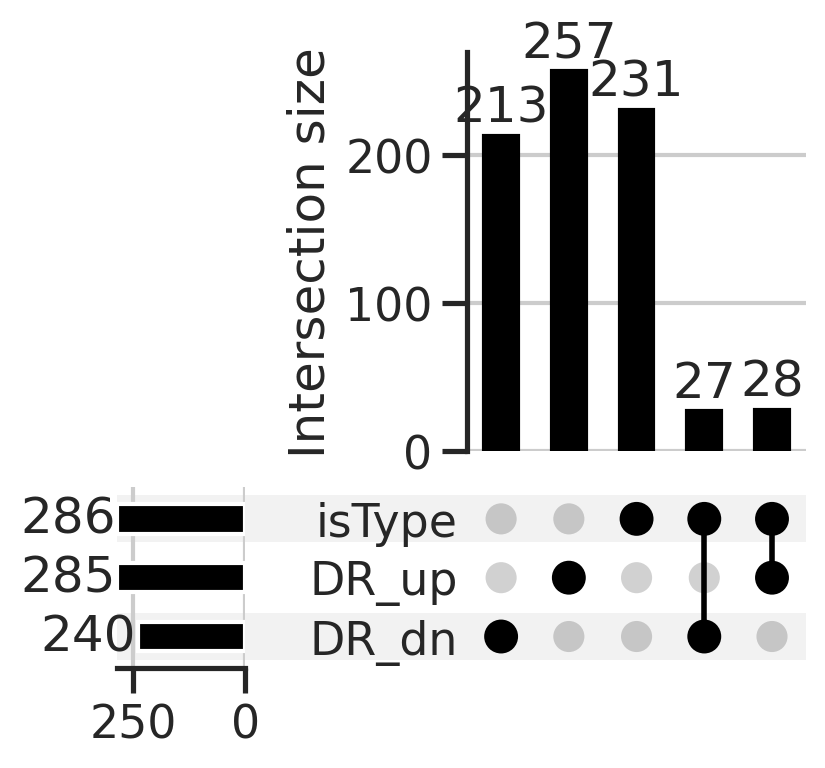

In [43]:
from upsetplot import plot, from_indicators

fig = plt.figure(figsize=(4,6))
plot(from_indicators(indicators=['isType', 'isDR'], data=dfplot), show_counts=True, fig=fig, sort_categories_by='-input')
plt.show()

fig = plt.figure(figsize=(4,6))
plot(from_indicators(indicators=['isType', 'DR_up', 'DR_dn'], data=dfplot), show_counts=True, fig=fig, sort_categories_by='-input')
plt.show()

# visualize those that goes up or down

In [44]:
plotgenes = df2.loc[df2['DR_DE'], 'gene'].values
plotgenes_annot = df2.loc[df2['DR_DE'], 'P17on'].values
plotgenes_idx = basicu.get_index_from_array(genes, plotgenes)

row = plotgenes
col = unq_types

In [45]:
a = pbulks[:,:,:,plotgenes_idx].T
a = np.swapaxes(a,2,3)
a0,a1,a2,a3 = a.shape # gene, type, cond, rep
am = zscore(np.mean(a, axis=(2,3)), axis=1)
af = zscore(a.reshape(a0, a1*a2*a3), axis=1)

rowidx = np.array(basicu.order_by_hc(af))
colidx = np.array([0,1,2])

colidx_expanded = np.ravel(a2*a3*colidx.reshape(-1,1) + np.repeat(np.arange(a2*a3).reshape(1,-1), len(colidx), axis=0))
col_expanded = np.ravel(np.repeat(np.arange(a2*a3).reshape(1,-1), len(col), axis=0))

In [46]:
nr_mean = np.mean(a, axis=3)[:,:,0]
a_lfc = np.log2(10)*(a-nr_mean.reshape(a0,a1,1,1))
af_lfc = a_lfc.reshape(a0, a1*a2*a3)

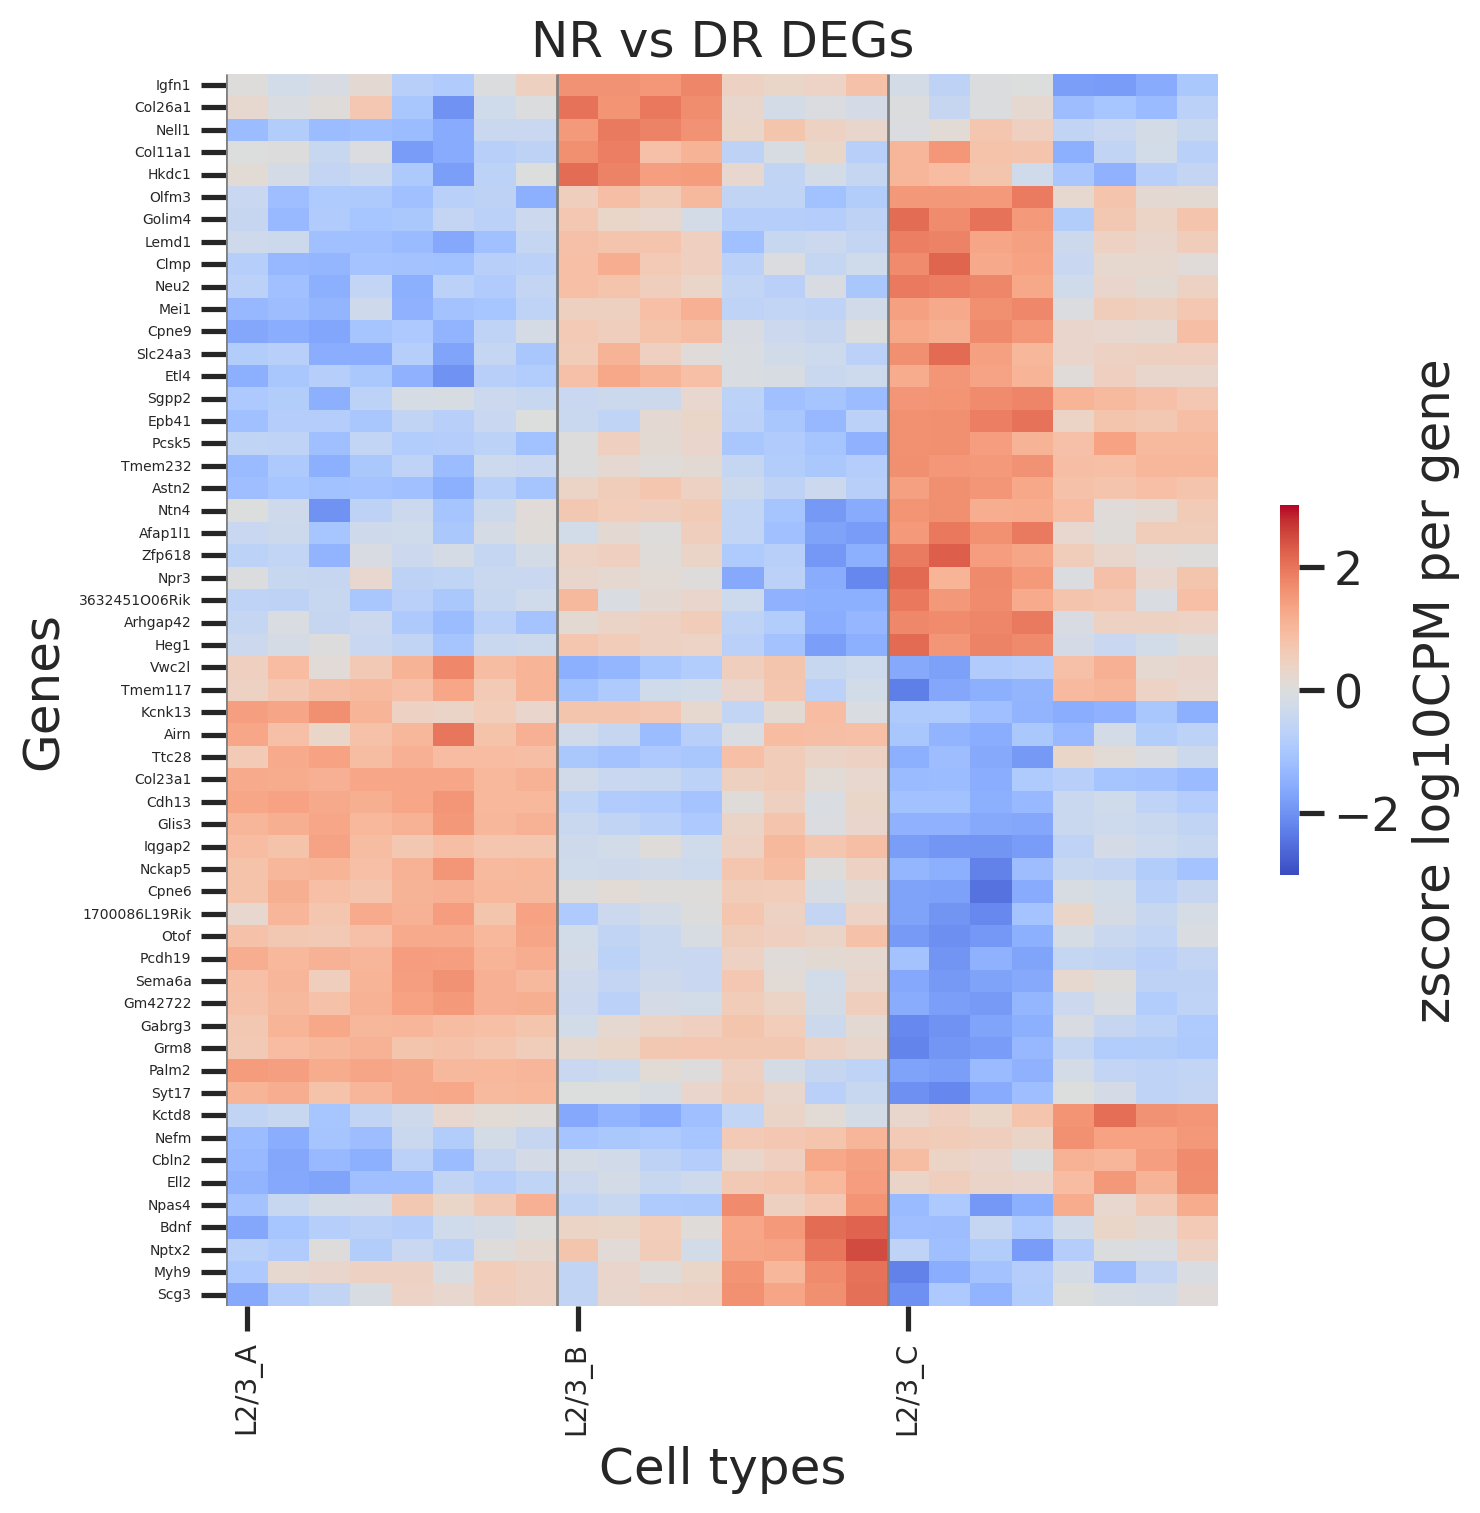

In [47]:
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(af[rowidx][:,colidx_expanded], 
            yticklabels=True,
            xticklabels=a2*a3,
            cbar_kws=dict(shrink=0.3, label='zscore log10CPM per gene'),
            cmap='coolwarm', 
            center=0, vmin=-3, vmax=3,
            ax=ax) 
ax.vlines(np.arange(0, a1*a2*a3, a2*a3), 0, a0, color='gray', linewidth=1)
ax.set_xticklabels(col[colidx], rotation=90, fontsize=10)
ax.set_yticklabels(row[rowidx], rotation=0, fontsize=5)
ax.set_ylabel('Genes')
ax.set_xlabel('Cell types')
ax.set_title('NR vs DR DEGs')
plt.show()

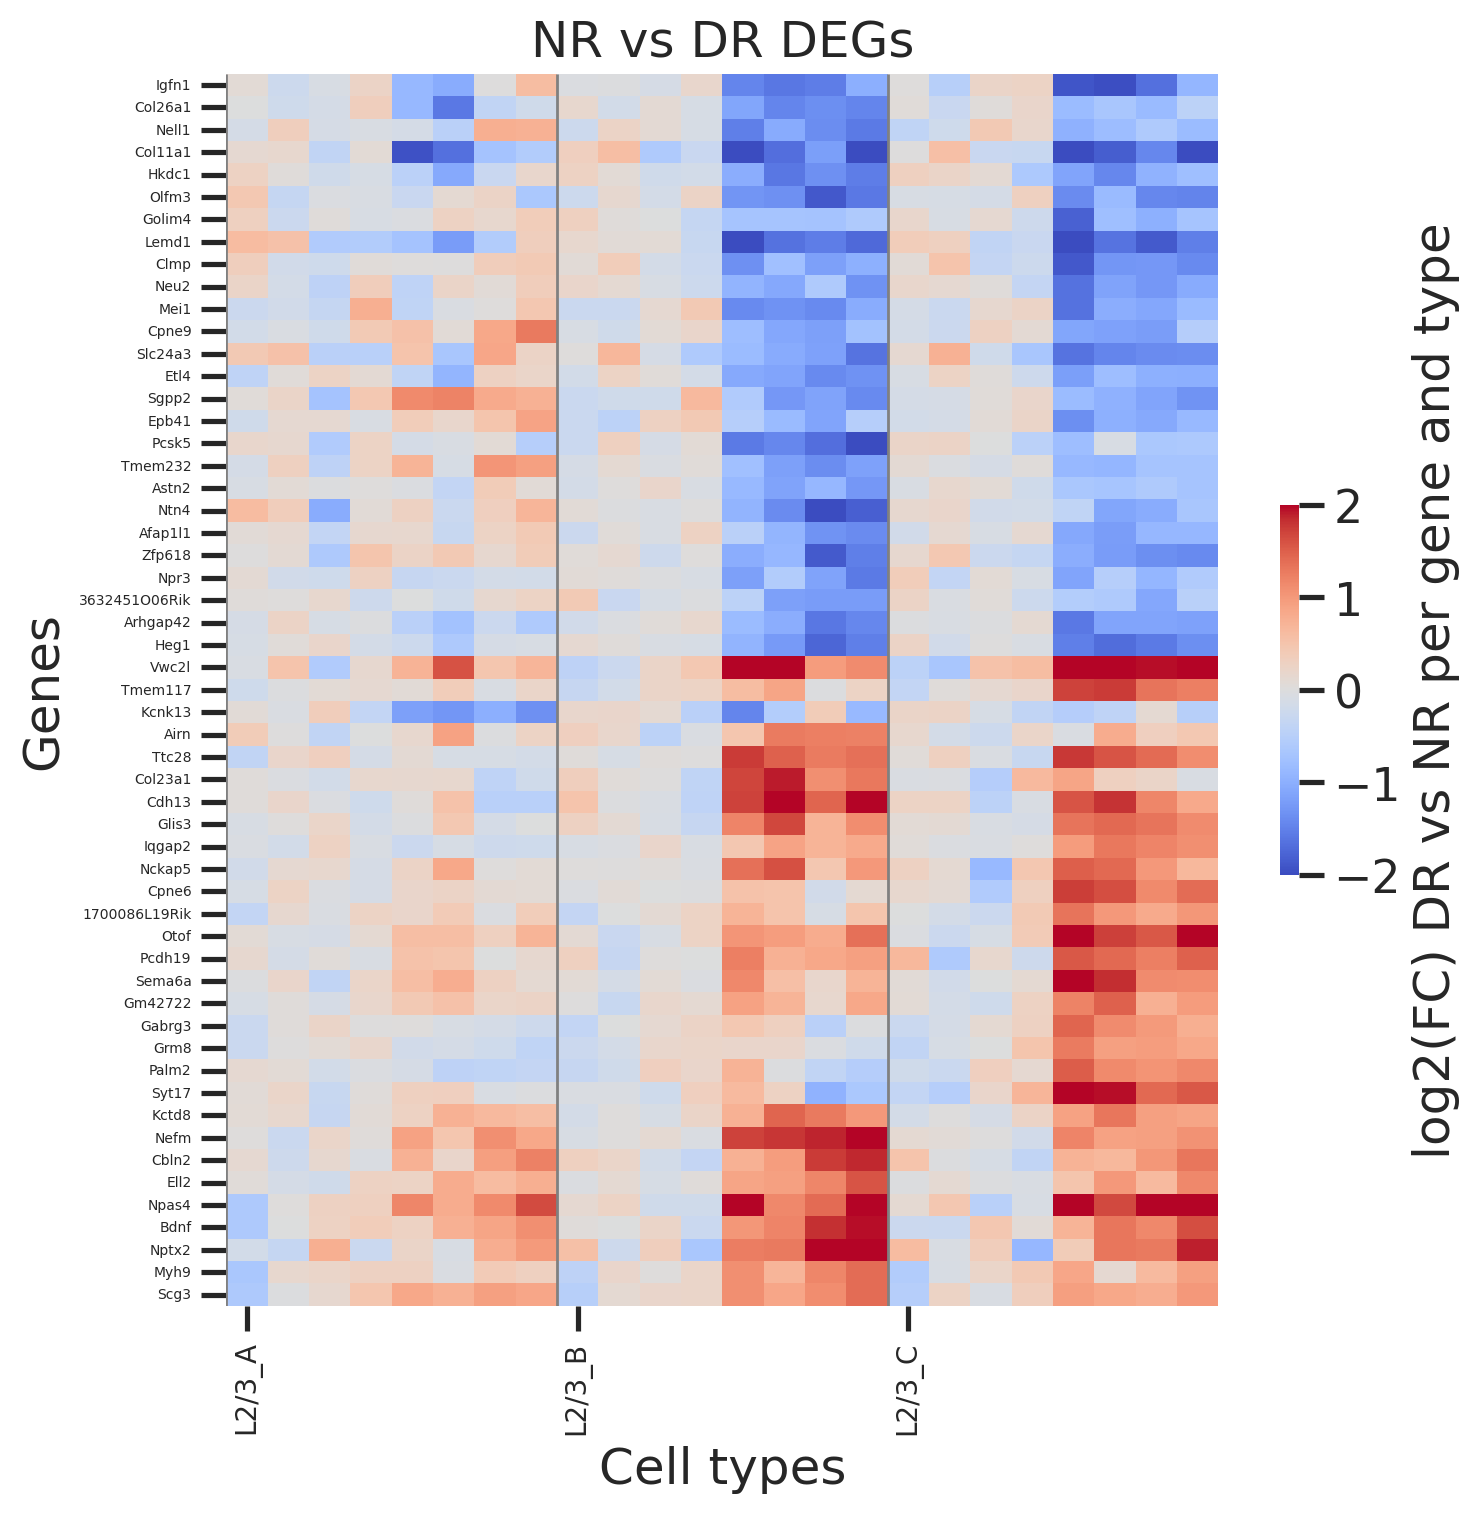

In [48]:
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(af_lfc[rowidx][:,colidx_expanded], 
            yticklabels=True, # 20, #degs[rowidx],
            xticklabels=a2*a3,
            cbar_kws=dict(shrink=0.3, label='log2(FC) DR vs NR per gene and type'),
            cmap='coolwarm', 
            center=0, vmin=-2, vmax=2,
            ax=ax) 
ax.vlines(np.arange(0, a1*a2*a3, a2*a3), 0, a0, color='gray', linewidth=1)
ax.set_xticklabels(col[colidx], rotation=90, fontsize=10)
ax.set_yticklabels(row[rowidx], rotation=0, fontsize=5)
ax.set_ylabel('Genes')
ax.set_xlabel('Cell types')
ax.set_title('NR vs DR DEGs')
plt.show()

# visualize FC for each 286 gene

In [49]:
df2.set_index('gene').loc[['Cdh13', 'Trpc6', 'Chrm2']]

group  ispicked P17on P14 DR  DR_DE DR_updn
gene                                             
Cdh13    A1      True     A  AB  1   True   DR_up
Trpc6    B0      True     B  AB  1  False     NaN
Chrm2    C0      True     C  BC  3  False     NaN

In [50]:
plotgenes = ['Cdh13', 'Trpc6', 'Chrm2']
plotgenes_annot = df2.set_index('gene').loc[plotgenes, 'P17on'].values
plotgenes_idx = basicu.get_index_from_array(genes, plotgenes)

row = plotgenes
col = unq_types

In [51]:
a = pbulks[:,:,:,plotgenes_idx].T
a = np.swapaxes(a,2,3)
a0,a1,a2,a3 = a.shape # gene, type, cond, rep
am = zscore(np.mean(a, axis=(2,3)), axis=1)
af = zscore(a.reshape(a0, a1*a2*a3), axis=1)

# rowidx = np.array(basicu.order_by_hc(af))
colidx = np.array([0,1,2])

colidx_expanded = np.ravel(a2*a3*colidx.reshape(-1,1) + np.repeat(np.arange(a2*a3).reshape(1,-1), len(colidx), axis=0))
col_expanded = np.ravel(np.repeat(np.arange(a2*a3).reshape(1,-1), len(col), axis=0))

In [52]:
nr_mean = np.mean(a, axis=3)[:,:,0]
a_lfc = np.log2(10)*(a-nr_mean.reshape(a0,a1,1,1))
af_lfc = a_lfc.reshape(a0, a1*a2*a3)

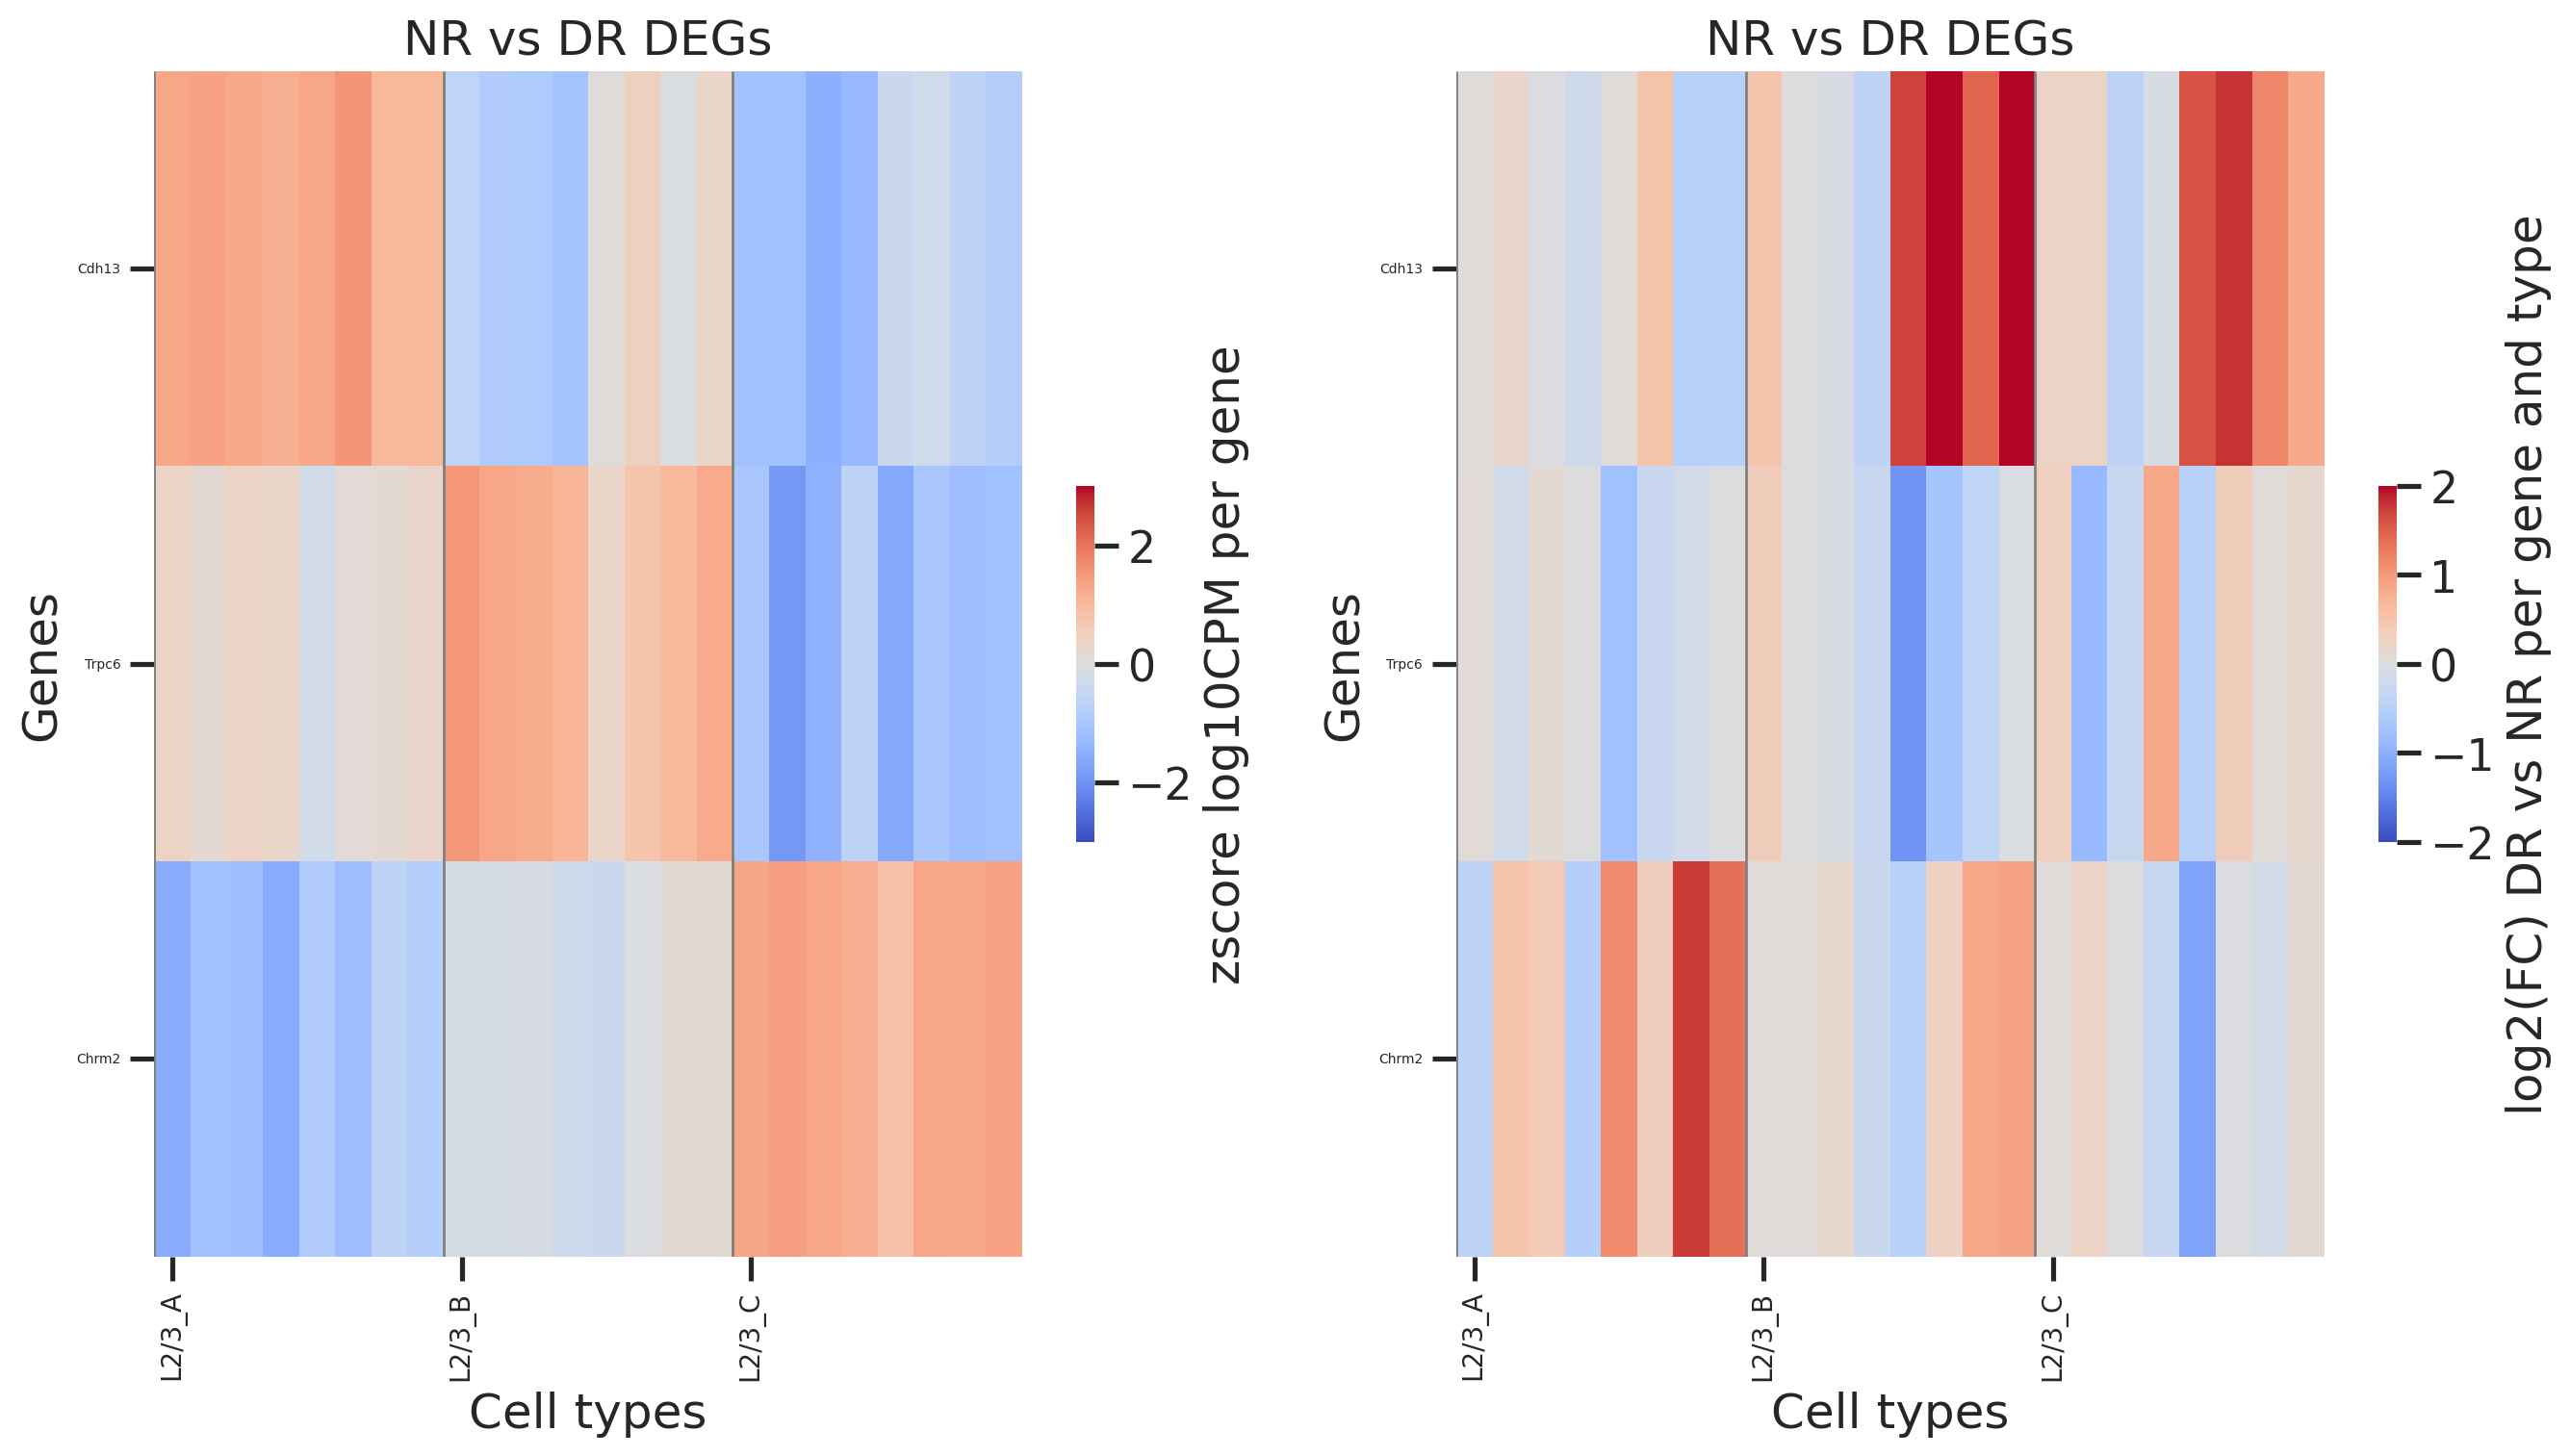

In [53]:
fig, axs = plt.subplots(1,2,figsize=(8*2,8))
ax = axs[0]
sns.heatmap(af[:,colidx_expanded], 
            yticklabels=True,
            xticklabels=a2*a3,
            cbar_kws=dict(shrink=0.3, label='zscore log10CPM per gene'),
            cmap='coolwarm', 
            center=0, vmin=-3, vmax=3,
            ax=ax) 
ax.vlines(np.arange(0, a1*a2*a3, a2*a3), 0, a0, color='gray', linewidth=1)
ax.set_xticklabels(col[colidx], rotation=90, fontsize=10)
ax.set_yticklabels(row, rotation=0, fontsize=5)
ax.set_ylabel('Genes')
ax.set_xlabel('Cell types')
ax.set_title('NR vs DR DEGs')

ax = axs[1]
sns.heatmap(af_lfc[:,colidx_expanded], 
            yticklabels=True, # 20, #degs[rowidx],
            xticklabels=a2*a3,
            cbar_kws=dict(shrink=0.3, label='log2(FC) DR vs NR per gene and type'),
            cmap='coolwarm', 
            center=0, vmin=-2, vmax=2,
            ax=ax) 
ax.vlines(np.arange(0, a1*a2*a3, a2*a3), 0, a0, color='gray', linewidth=1)
ax.set_xticklabels(col[colidx], rotation=90, fontsize=10)
ax.set_yticklabels(row, rotation=0, fontsize=5)
ax.set_ylabel('Genes')
ax.set_xlabel('Cell types')
ax.set_title('NR vs DR DEGs')
plt.show()

In [54]:
# level of up and down
print(a.shape)  # gene, type, cond, rep
nr_mean = np.mean(a, axis=3)[:,:,0] # mean over 4 samples
dr_mean = np.mean(a, axis=3)[:,:,1] # mean over 4 samples

(3, 3, 2, 4)


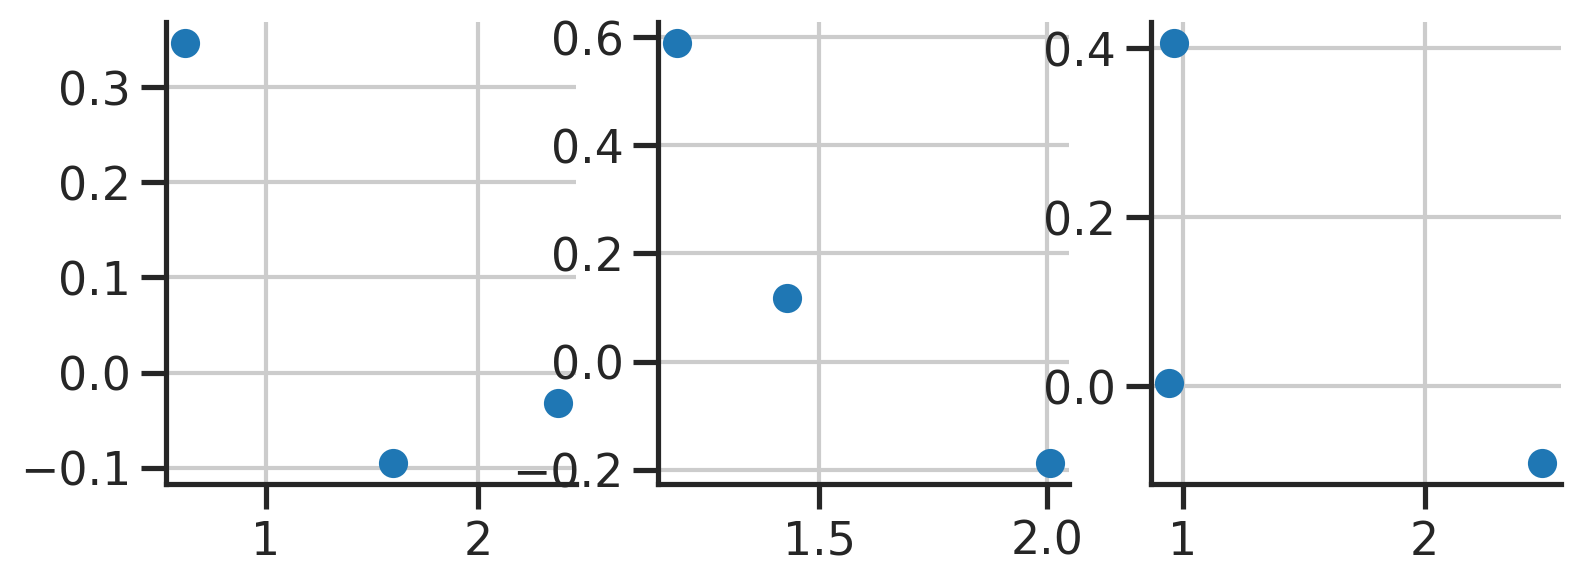

In [55]:
fig, axs = plt.subplots(1,3,figsize=(3*3,3))
for i in range(3):
    ax = axs[i]
    ax.scatter(nr_mean[:,i], dr_mean[:,i]-nr_mean[:,i])
    # ax.plot([0,3], [0,3], color='gray', zorder=0)
    # ax.set_xticks([0,1,2,3])
    # ax.set_yticks([0,1,2,3])
    # ax.set_aspect('equal')
    sns.despine(ax=ax)
plt.show()


In [56]:
types_order = [
    'L2/3_A', 
    'L2/3_B', 
    'L2/3_C', 
]
len(types_order)

3

In [57]:
np.intersect1d(genes_comm, df2.gene).shape

(286,)

In [58]:
def show_volcano(thetypeidx, thetype, lfc, qs, cond1, cond2up, cond2dn, ax=None, bbox_to_anchor=(1,1), loc=None):
    """
    Gene by type matrices: 
        lfc matrix: log fold change
        qs matirx:
    
        cond1 : significant or not? 
        cond2up: FC above the cutoff?
        cond2dn: FC below the cutoff?
    
    thetypeidx: pick a type - one column index from the above matrices
    """
    eff = lfc[:,thetypeidx]
    pvl =  qs[:,thetypeidx]

    cnd_up = np.all([cond1[:,thetypeidx], 
                     cond2up[:,thetypeidx]], axis=0) 
    cnd_dn = np.all([cond1[:,thetypeidx], 
                     cond2dn[:,thetypeidx]], axis=0) 

    if ax is None: 
        fig, ax = plt.subplots()
        
    ax.scatter(eff, -np.log10(pvl), s=1, color='gray')

    ax.scatter(eff[cnd_up], -np.log10(pvl)[cnd_up], s=5, #s=5, 
               label=f'DR up (n={cnd_up.sum():,})')
    ax.scatter(eff[cnd_dn], -np.log10(pvl)[cnd_dn], s=5, #s=5, 
               label=f'DR dn (n={cnd_dn.sum():,})')

    ax.set_xlabel('log2(FC) (DR/NR in CPM)')
    ax.set_ylabel('-log10(FDR)')
    ax.set_title(f'{thetype}')
    ax.legend(bbox_to_anchor=bbox_to_anchor, loc=loc)
    return ax

In [59]:
def show_volcano_v2(thetypeidx, thetype, lfc, qs,
                    cond1, cond2up, cond2dn, 
                    querygenes_idx, 
                    gene_annots=None,
                    ax=None, bbox_to_anchor=(1,1), loc=None,
                   ): 
    """
    """
    eff = lfc[:,thetypeidx]
    pvl = -np.log10(qs[:,thetypeidx])
    cnd_up = np.all([cond1[:,thetypeidx], 
                     cond2up[:,thetypeidx]], axis=0) 
    cnd_dn = np.all([cond1[:,thetypeidx], 
                     cond2dn[:,thetypeidx]], axis=0) 

    if ax is None: 
        fig, ax = plt.subplots()
    
    # all genes
    ax.scatter(eff, pvl, s=1, color='lightgray', rasterized=True)

    # up genes
    ax.scatter(eff[cnd_up], pvl[cnd_up], s=3, 
               label=f'DR up (n={cnd_up.sum():,})', facecolors='C0', rasterized=True)
    # dn genes
    ax.scatter(eff[cnd_dn], pvl[cnd_dn], s=3, 
               label=f'DR dn (n={cnd_dn.sum():,})', facecolors='C1', rasterized=True)
    
    # type genes
    ax.scatter(eff[querygenes_idx], pvl[querygenes_idx], s=15, 
               label=f'type-specific (n={len(querygenes_idx):,})', facecolors='none', edgecolors='k', linewidth=1, rasterized=True)
    
    # add text
    if gene_annots is not None:
        for idx in querygenes_idx:
            ax.text(eff[idx], pvl[idx], gene_annots[idx])

    ax.set_xlabel('log2(FC) (DR/NR in CPM)')
    ax.set_ylabel('-log10(FDR)')
    ax.set_title(f'{thetype}')
    ax.legend(bbox_to_anchor=bbox_to_anchor, loc=loc)
    return 

In [60]:
typegenes_idx = basicu.get_index_from_array(genes_comm, df2.gene)

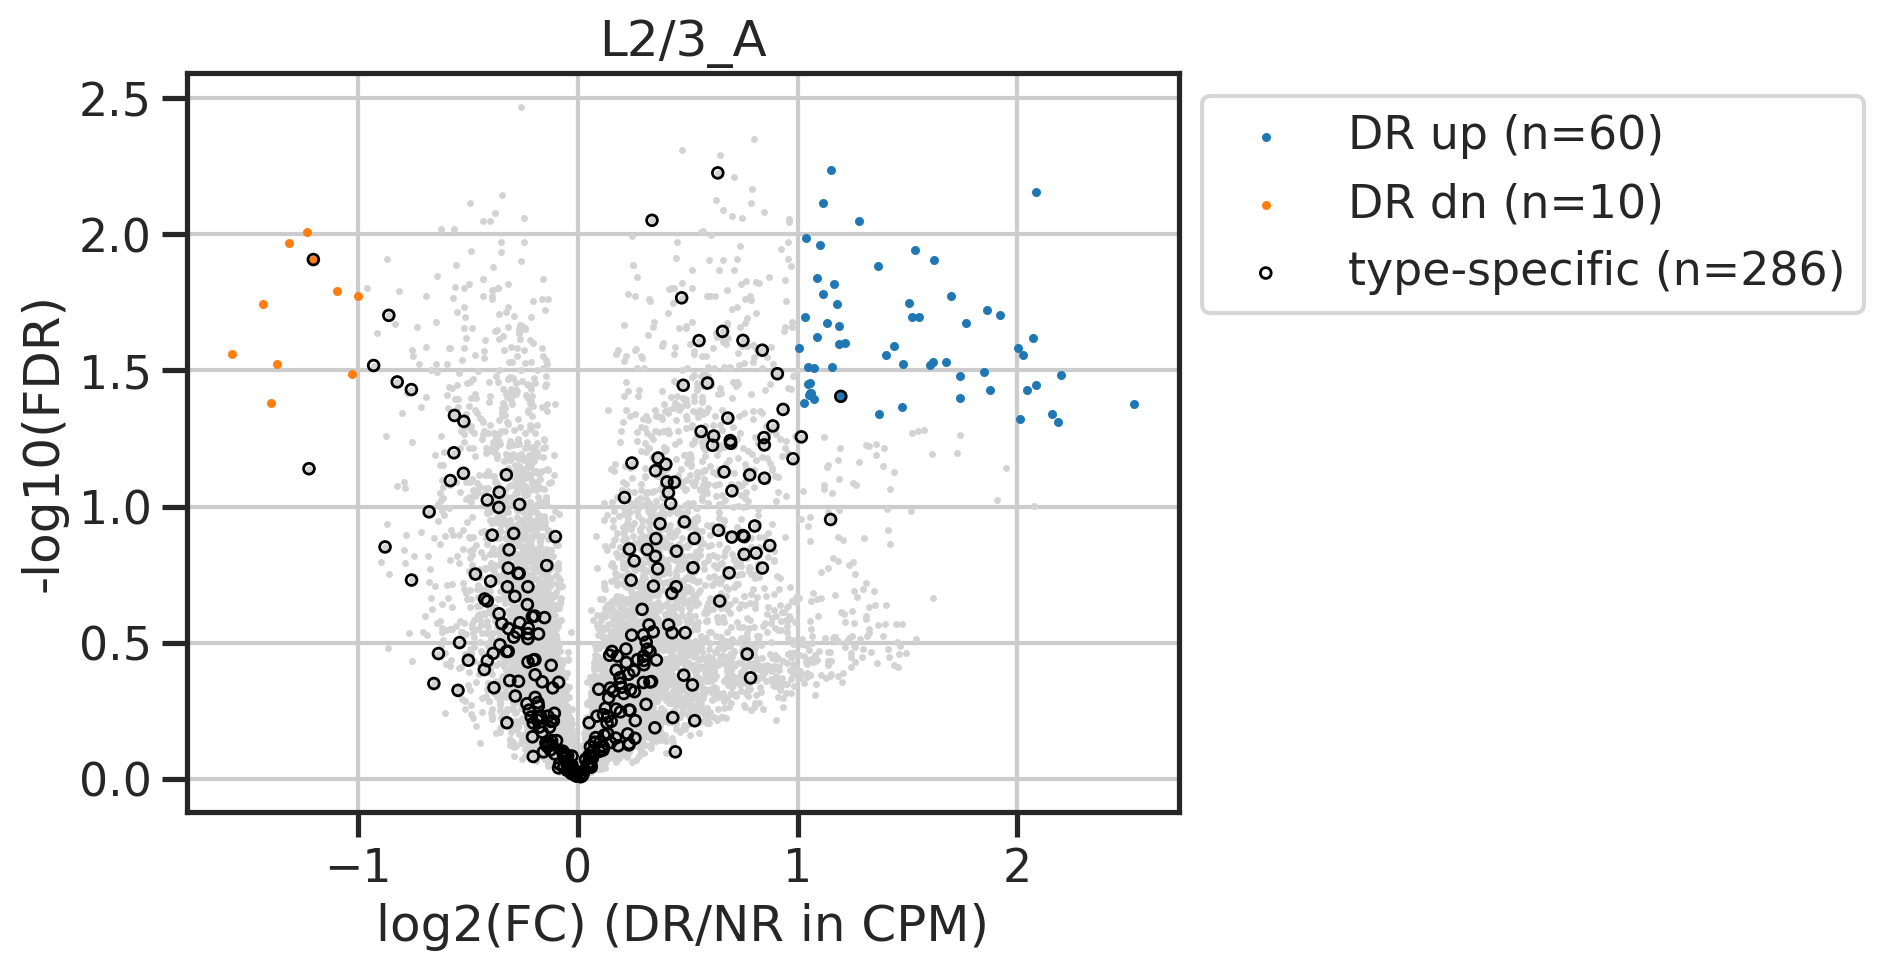

In [61]:
thetypeidx = 0 # type A 
thetype = 'L2/3_A'
show_volcano_v2(thetypeidx, thetype, lfc, qs, cond1, cond2up, cond2dn, typegenes_idx)

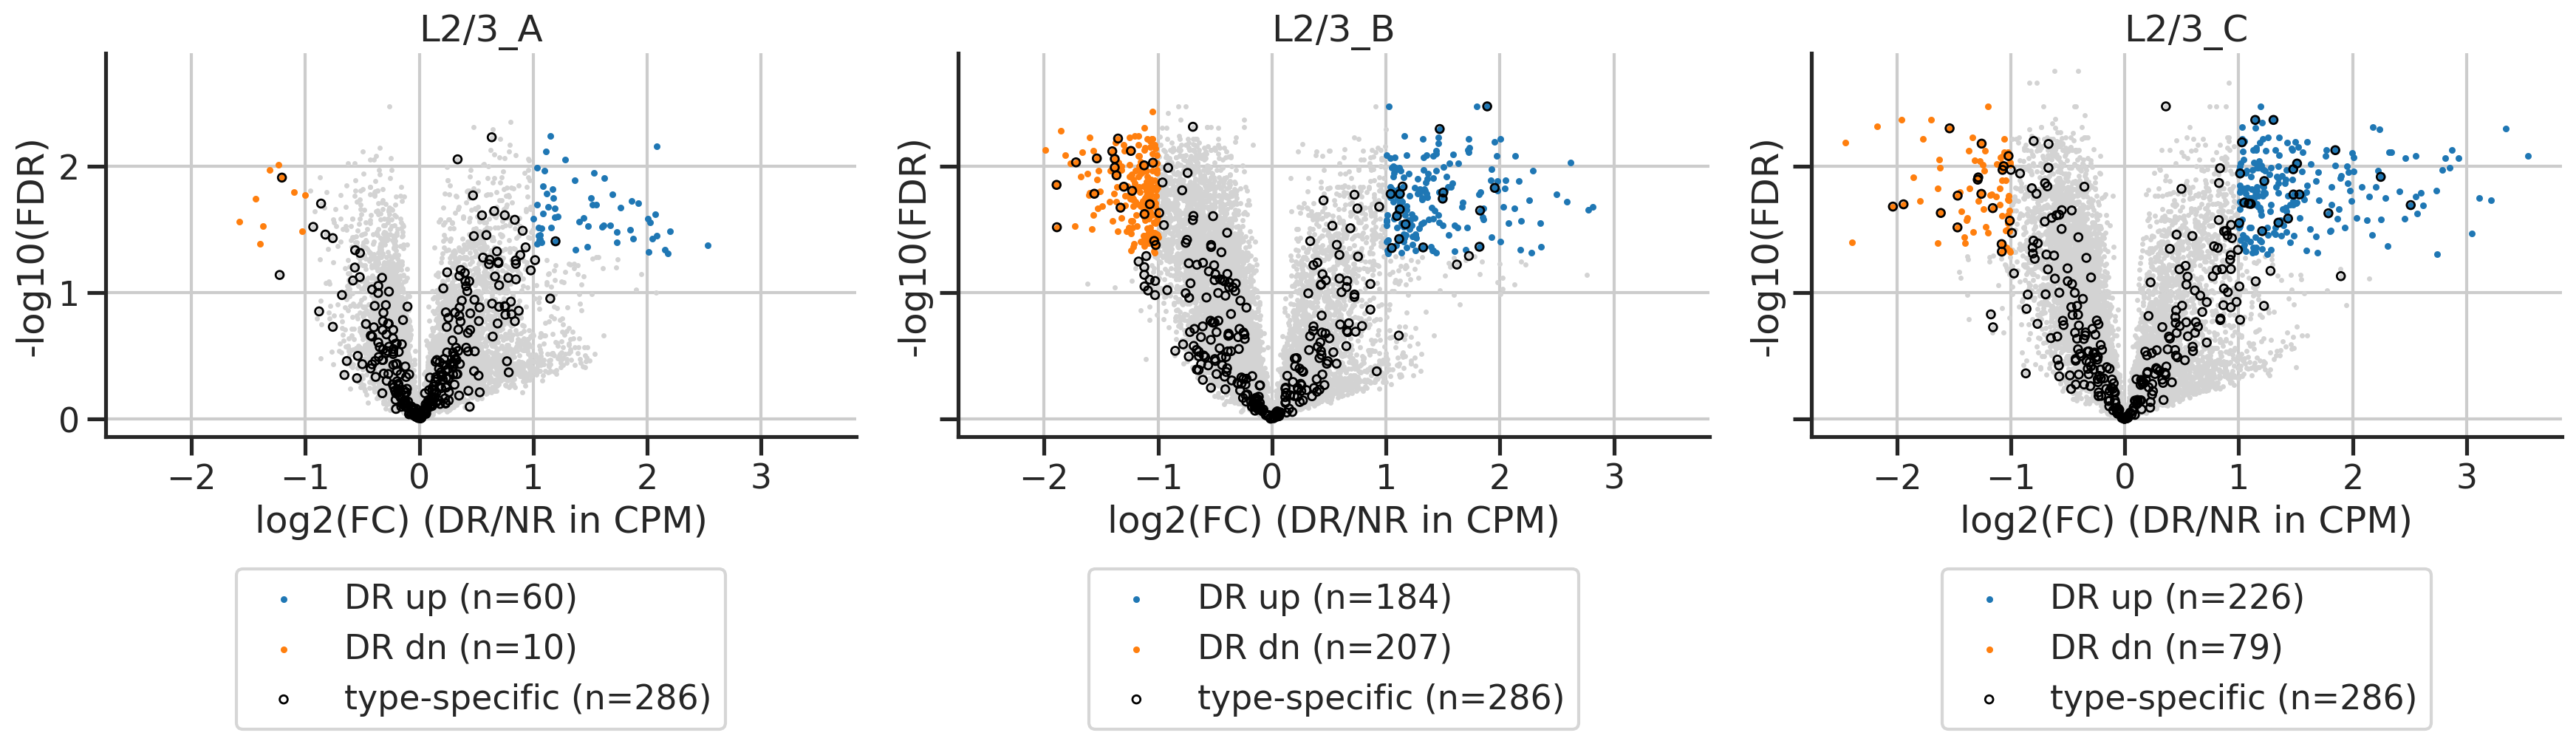

In [62]:
fig, axs = plt.subplots(1,3,figsize=(6*3,6*1), sharex=True, sharey=True)
for thetypeidx, thetype in enumerate(unq_types):
    assert thetypeidx != -1
    ax = axs.flat[thetypeidx]
    show_volcano_v2(thetypeidx, thetype, lfc, qs, cond1, cond2up, cond2dn, 
                    typegenes_idx, 
                    ax=ax, bbox_to_anchor=(0.5, -0.3), loc='upper center')
    sns.despine(ax=ax)
fig.tight_layout()
plt.show()

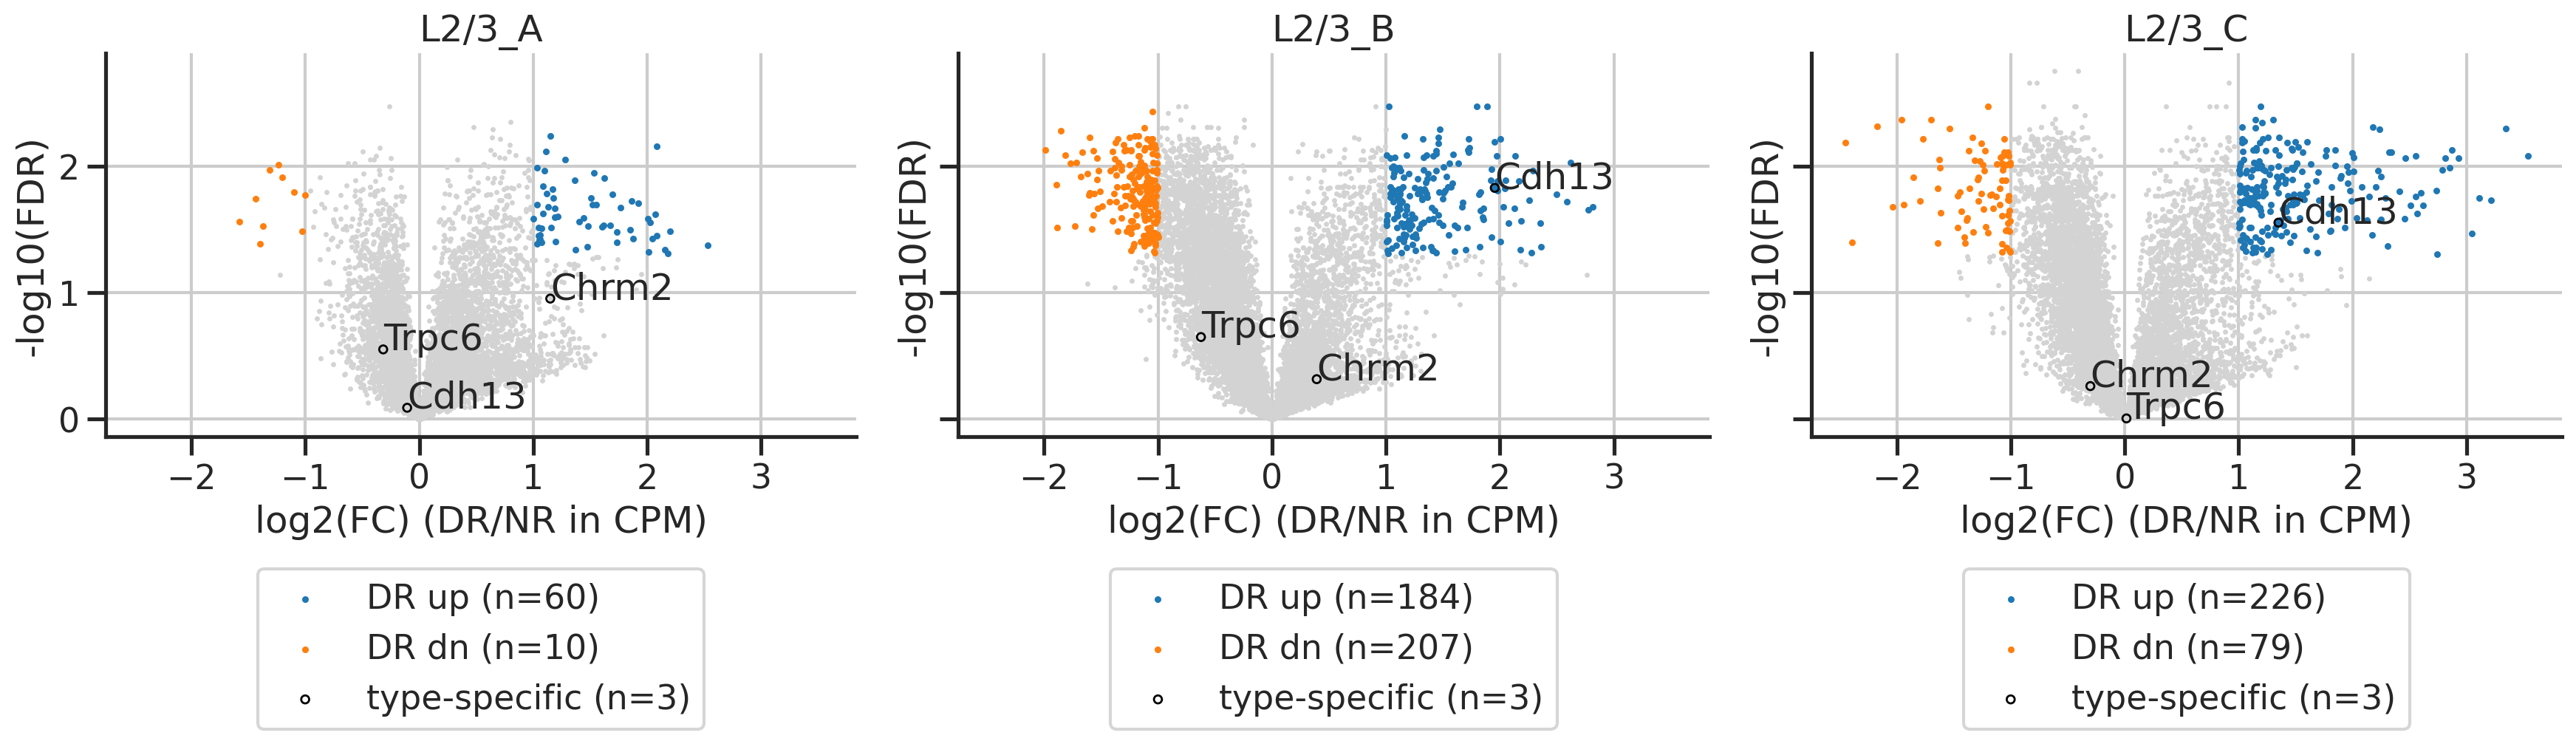

In [63]:
querygenes = ['Cdh13', 'Trpc6', 'Chrm2']
querygenes_idx = basicu.get_index_from_array(genes_comm, querygenes) 
    
fig, axs = plt.subplots(1,3,figsize=(6*3,6*1), sharex=True, sharey=True)
for thetypeidx, thetype in enumerate(unq_types):
    assert thetypeidx != -1
    ax = axs.flat[thetypeidx]
    show_volcano_v2(thetypeidx, thetype, lfc, qs, cond1, cond2up, cond2dn, 
                    querygenes_idx, 
                    gene_annots=genes_comm,
                    ax=ax, bbox_to_anchor=(0.5, -0.3), loc='upper center')
    sns.despine(ax=ax)
fig.tight_layout()
plt.show()

# visualize DR unchanged genes

In [64]:
plotgenes = df2.loc[~df2['DR_DE'], 'gene'].values
print(plotgenes.shape)
plotgenes_annot = df2.set_index('gene').loc[plotgenes, 'P17on'].values
plotgenes_idx = basicu.get_index_from_array(genes, plotgenes)

row = plotgenes
col = unq_types

(231,)


In [65]:
a = pbulks[:,:,:,plotgenes_idx].T
a = np.swapaxes(a,2,3)
a0,a1,a2,a3 = a.shape # gene, type, cond, rep
am = zscore(np.mean(a, axis=(2,3)), axis=1)
af = zscore(a.reshape(a0, a1*a2*a3), axis=1)

rowidx = np.array(basicu.order_by_hc(af))
colidx = np.array([0,1,2])

colidx_expanded = np.ravel(a2*a3*colidx.reshape(-1,1) + np.repeat(np.arange(a2*a3).reshape(1,-1), len(colidx), axis=0))
col_expanded = np.ravel(np.repeat(np.arange(a2*a3).reshape(1,-1), len(col), axis=0))

In [66]:
nr_mean = np.mean(a, axis=3)[:,:,0]
a_lfc = np.log2(10)*(a-nr_mean.reshape(a0,a1,1,1))
af_lfc = a_lfc.reshape(a0, a1*a2*a3)

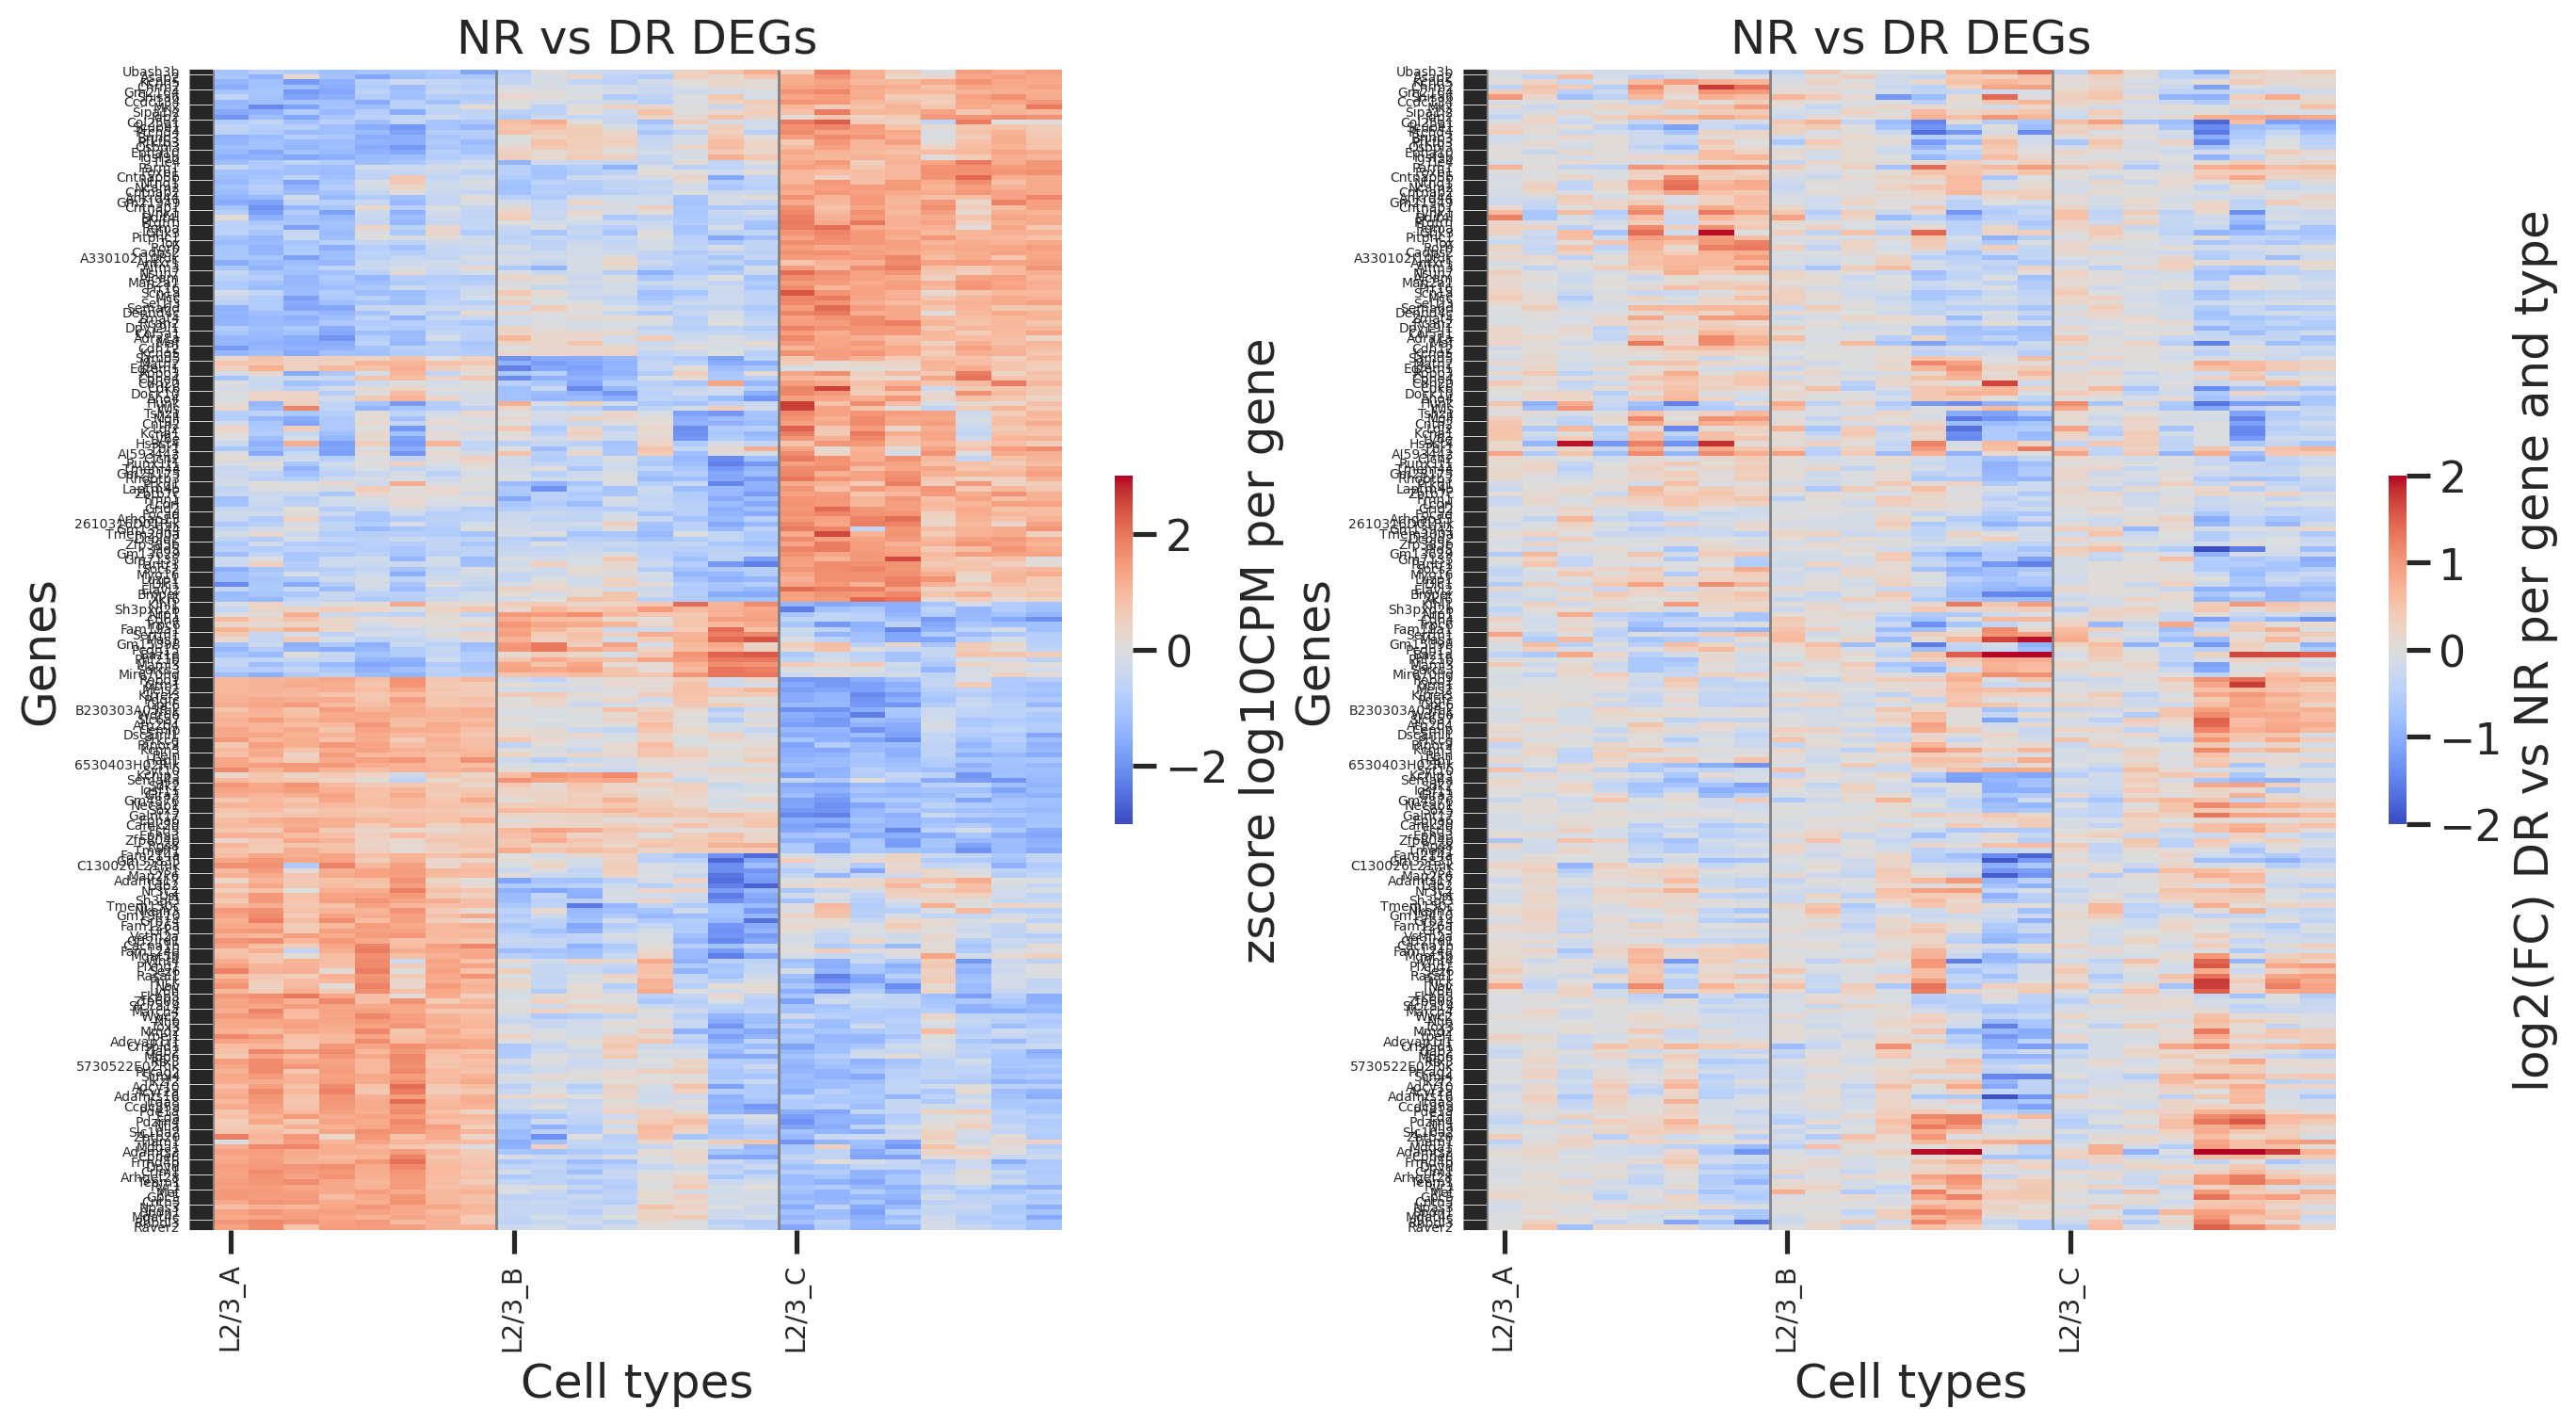

In [67]:
fig, axs = plt.subplots(1,2,figsize=(8*2,8))
ax = axs[0]
sns.heatmap(af[rowidx][:,colidx_expanded], 
            yticklabels=True,
            xticklabels=a2*a3,
            cbar_kws=dict(shrink=0.3, label='zscore log10CPM per gene'),
            cmap='coolwarm', 
            center=0, vmin=-3, vmax=3,
            ax=ax) 
ax.vlines(np.arange(0, a1*a2*a3, a2*a3), 0, a0, color='gray', linewidth=1)
ax.set_xticklabels(col[colidx], rotation=90, fontsize=10)
ax.set_yticklabels(row[rowidx], rotation=0, fontsize=5)
ax.set_ylabel('Genes')
ax.set_xlabel('Cell types')
ax.set_title('NR vs DR DEGs')

ax = axs[1]
sns.heatmap(af_lfc[rowidx][:,colidx_expanded], 
            yticklabels=True, # 20, #degs[rowidx],
            xticklabels=a2*a3,
            cbar_kws=dict(shrink=0.3, label='log2(FC) DR vs NR per gene and type'),
            cmap='coolwarm', 
            center=0, vmin=-2, vmax=2,
            ax=ax) 
ax.vlines(np.arange(0, a1*a2*a3, a2*a3), 0, a0, color='gray', linewidth=1)
ax.set_xticklabels(col[colidx], rotation=90, fontsize=10)
ax.set_yticklabels(row[rowidx], rotation=0, fontsize=5)
ax.set_ylabel('Genes')
ax.set_xlabel('Cell types')
ax.set_title('NR vs DR DEGs')
plt.show()

# proportions of ABC cells

In [68]:
tmp = meta[meta['cond'].isin(['P28NR', 'P28DR', 'P38NR', 'P38DR', 'P28DL'])].copy()
tmp['biosample'] = tmp['sample'].apply(lambda x: x[:-1])

In [69]:
# tmp['newcond'] = tmp['easisamp']
typecounts = tmp.groupby(['biosample', 'newtype']).size().unstack()
typecounts

newtype    L2/3_A  L2/3_B  L2/3_C
biosample                        
P28_1         438    1119     514
P28_2         565     968     440
P28_dl_1      737    1157     473
P28_dl_2      570    1157     565
P28_dr_1      787     726     498
P28_dr_3      884    1154     655
P38_1         108     422     190
P38_2         523    1056     398
P38_dr_1     1080     719     627
P38_dr_2     1120     854     765

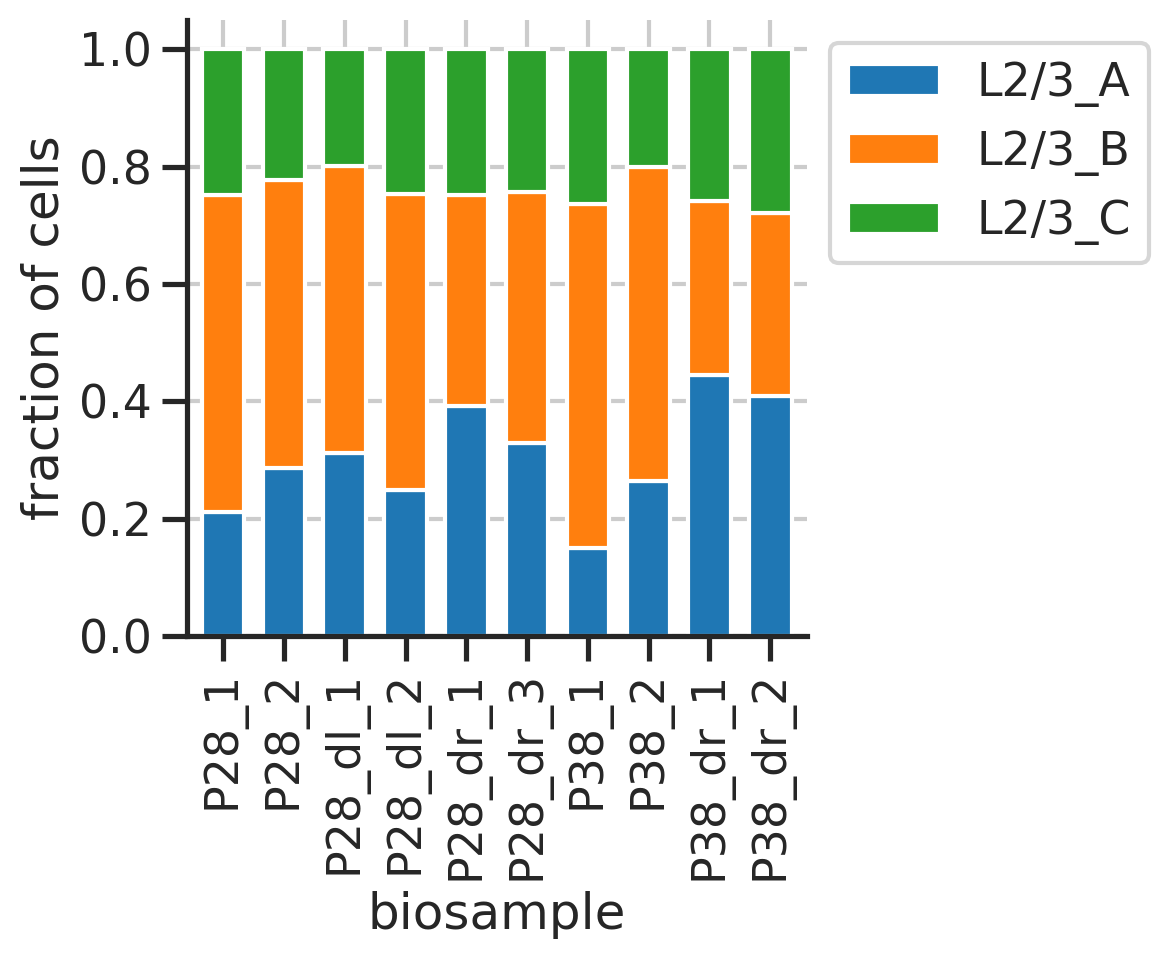

In [70]:
fig, ax = plt.subplots(figsize=(4,4))
typecounts.divide(typecounts.sum(axis=1), axis=0).plot.bar(width=0.7, stacked=True, ax=ax)
ax.legend(bbox_to_anchor=(1,1))
ax.set_ylabel('fraction of cells')
sns.despine(ax=ax)
plt.show()

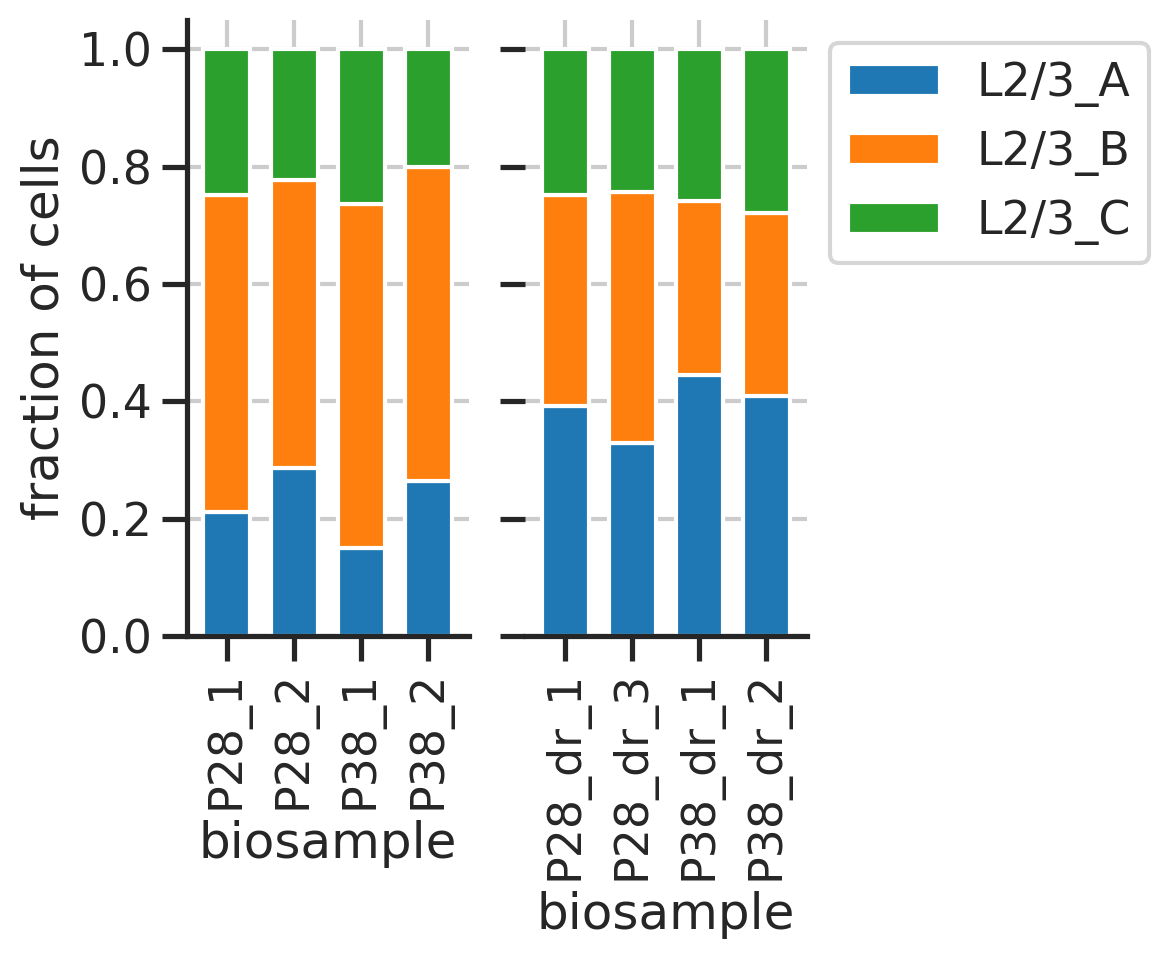

In [71]:
fig, axs = plt.subplots(1,2,figsize=(4,4), sharey=True)
ax = axs[0]
typecounts.divide(typecounts.sum(axis=1), axis=0).loc[
    ['P28_1', 'P28_2', 'P38_1','P38_2', 
    ]].plot.bar(width=0.7, stacked=True, ax=ax,legend=False)
# ax.legend(bbox_to_anchor=(1,1))
ax.set_ylabel('fraction of cells')
sns.despine(ax=ax)

ax = axs[1]
typecounts.divide(typecounts.sum(axis=1), axis=0).loc[
    ['P28_dr_1', 'P28_dr_3', 'P38_dr_1','P38_dr_2', 
    ]].plot.bar(width=0.7, stacked=True, ax=ax)
ax.legend(bbox_to_anchor=(1,1))
ax.set_ylabel('fraction of cells')
sns.despine(ax=ax, left=True)

plt.show()

# DR ABC genes 

In [101]:
dr_abc_uniq_genes = np.array([
    'Fam13a', 'Mtmr10', 'Slain1', 'Rufy1', 'Mpped2', 'D130043K22Rik',
    'Dennd2a', 'Gm5577', 'Pdcd4', 'Lypd1', 'Fxyd6', 'Hlcs', 'Palmd',
    'Ankrd6', 'Cdon', 'Fbxo10', 'Tiam2', 'Fancl', 'Stum', 'Scn3b',
    'Sesn3', 'Cyr61', 'Myo1e', 'Sema3a', 'Mapk4', 'Eepd1', 'Plekhh2',
    'Rph3a', 'Cdh18', 'Rassf3', 'Syndig1', 'Tmem178', 'Elmo1', 'Ptprm',
    'Ccng1', 'Specc1', 'Tspan17', 'Cpsf6', 'Gm2824', 'Zdhhc2',
    'Cited2', 'Hcn1', 'Ccdc136', 'Ern1', 'Efnb2', 'Ndst3', 'Dtnbp1',
])
dr_abc_uniq_genes.shape

(47,)

In [102]:
dr_abc_genes = np.array(['Crispld1', 'Dpyd', 'Adamts2', 'Tox3', 'Gm19410', 'Fam13a',
       'Fam126a', 'Map2k6', 'Zfp608', 'Fam214a', 'Grk3', 'Nfib', 'Vstm2a',
       'Mtmr10', 'Fam124a', 'Mmd2', 'Slain1', 'Rufy1', 'Cys1', 'Mpped2',
       'Wwc2', 'D130043K22Rik', 'Dennd2a', 'Gm5577', 'Pdcd4', 'Matn2',
       'Col23a1', 'Lypd1', 'Igsf11', 'Kcnn3', 'Glra3', 'Gm4876', 'Slc6a7',
       'Hap1', 'Otof', 'Rfx3', 'Nckap5', 'Robo1', 'Cntn5', 'Ryr3',
       'Glis3', 'Epha6', 'Fxyd6', 'Necab1', 'Prkcg', 'Dscaml1', 'Atp2b4',
       'Hlcs', 'Wdr66', 'Cemip', 'Palmd', 'Pdzrn4', 'Epha3', 'Ankrd6',
       'Mgat4c', '6530403H02Rik', 'Cdh13', 'Pcdh19', 'Ikzf2', 'Spon1',
       'Itga8', 'Cdon', 'Slc7a14', 'Syt17', 'Gpc5', 'Palm2', 'Sema6a',
       'Arhgef28', 'Nov', 'Fbxo10', 'Mpp6', 'Gm42722', 'March4', 'Frmd4b',
       'Eda', 'Tiam2', 'Ccdc85a', 'Tenm1', 'Plxnd1', 'Fancl', 'Stum',
       'Scn3b', 'Adcyap1r1', 'Sesn3', 'Cyr61', 'Myo1e', 'Mir670hg',
       'Baz1a', 'Maml3', 'Sorcs3', 'Sema3a', 'Nptx2', 'Phf21b', 'Bdnf',
       'Mapk4', 'Scg3', 'Myh9', 'Epha10', 'Ptchd4', 'Osbpl3', 'Etl4',
       'Cdh12', 'Eepd1', 'Plekhh2', 'Ell2', 'Rph3a', 'Cdh18', 'Igsf9b',
       'Rassf3', 'Kcnq5', 'Syndig1', 'Tmem178', 'Cpne9', 'Elmo1',
       'Gm13629', 'Chrm2', 'Rorb', 'Parm1', 'Ptprm', 'Tox', 'Cadps2',
       'Pcsk5', 'Tmem232', 'Dcbld2', 'Ddit4l', 'Zmat4', 'Gm2164', 'Ncam2',
       'Socs2', 'A330102I10Rik', 'Ccng1', 'Nefm', 'Pitpnc1', 'Mcc',
       'Myo16', 'Cntnap2', 'Zfp385b', 'Epb41', 'Cntnap5b', 'Gm28175',
       'Ntng1', 'Aifm3', 'Foxp1', 'Specc1', 'Tspan17', 'Tmem44', 'Cpsf6',
       'Ly6e', 'Astn2', 'Man2a1', 'Lynx1', 'Kcnh5', 'Dpy19l1', 'Prr16',
       'Scube1', 'Ccdc134', 'Alcam', 'Bmper', 'Antxr1', 'Gm2824',
       'Slc24a3', 'Jdp2', 'Cbln2', 'AI593442', 'Sema6d', 'Sel1l3', 'Mgll',
       'Zdhhc2', 'Cited2', 'Hcn1', 'Dlc1', 'Rcan2', 'Tbr1', 'Kctd8',
       'Ccdc136', 'Cdh20', 'Zbtb7c', 'Ern1', 'Efnb2', 'Laptm4b', 'Ndst3',
       'Dtnbp1'])
dr_abc_genes.shape

(182,)

In [103]:
plotgenes = dr_abc_uniq_genes #df2.loc[~df2['DR_DE'], 'gene'].values
print(plotgenes.shape)
# plotgenes_annot = df2.set_index('gene').loc[plotgenes, 'P17on'].values
plotgenes_idx = basicu.get_index_from_array(genes, plotgenes)

row = plotgenes
col = unq_types

(47,)


In [104]:
a = pbulks[:,:,:,plotgenes_idx].T
a = np.swapaxes(a,2,3)
a0,a1,a2,a3 = a.shape # gene, type, cond, rep
am = zscore(np.mean(a, axis=(2,3)), axis=1)
af = zscore(a.reshape(a0, a1*a2*a3), axis=1)

rowidx = np.array(basicu.order_by_hc(af))
colidx = np.array([0,1,2])

colidx_expanded = np.ravel(a2*a3*colidx.reshape(-1,1) + np.repeat(np.arange(a2*a3).reshape(1,-1), len(colidx), axis=0))
col_expanded = np.ravel(np.repeat(np.arange(a2*a3).reshape(1,-1), len(col), axis=0))

In [105]:
nr_mean = np.mean(a, axis=3)[:,:,0]
a_lfc = np.log2(10)*(a-nr_mean.reshape(a0,a1,1,1))
af_lfc = a_lfc.reshape(a0, a1*a2*a3)

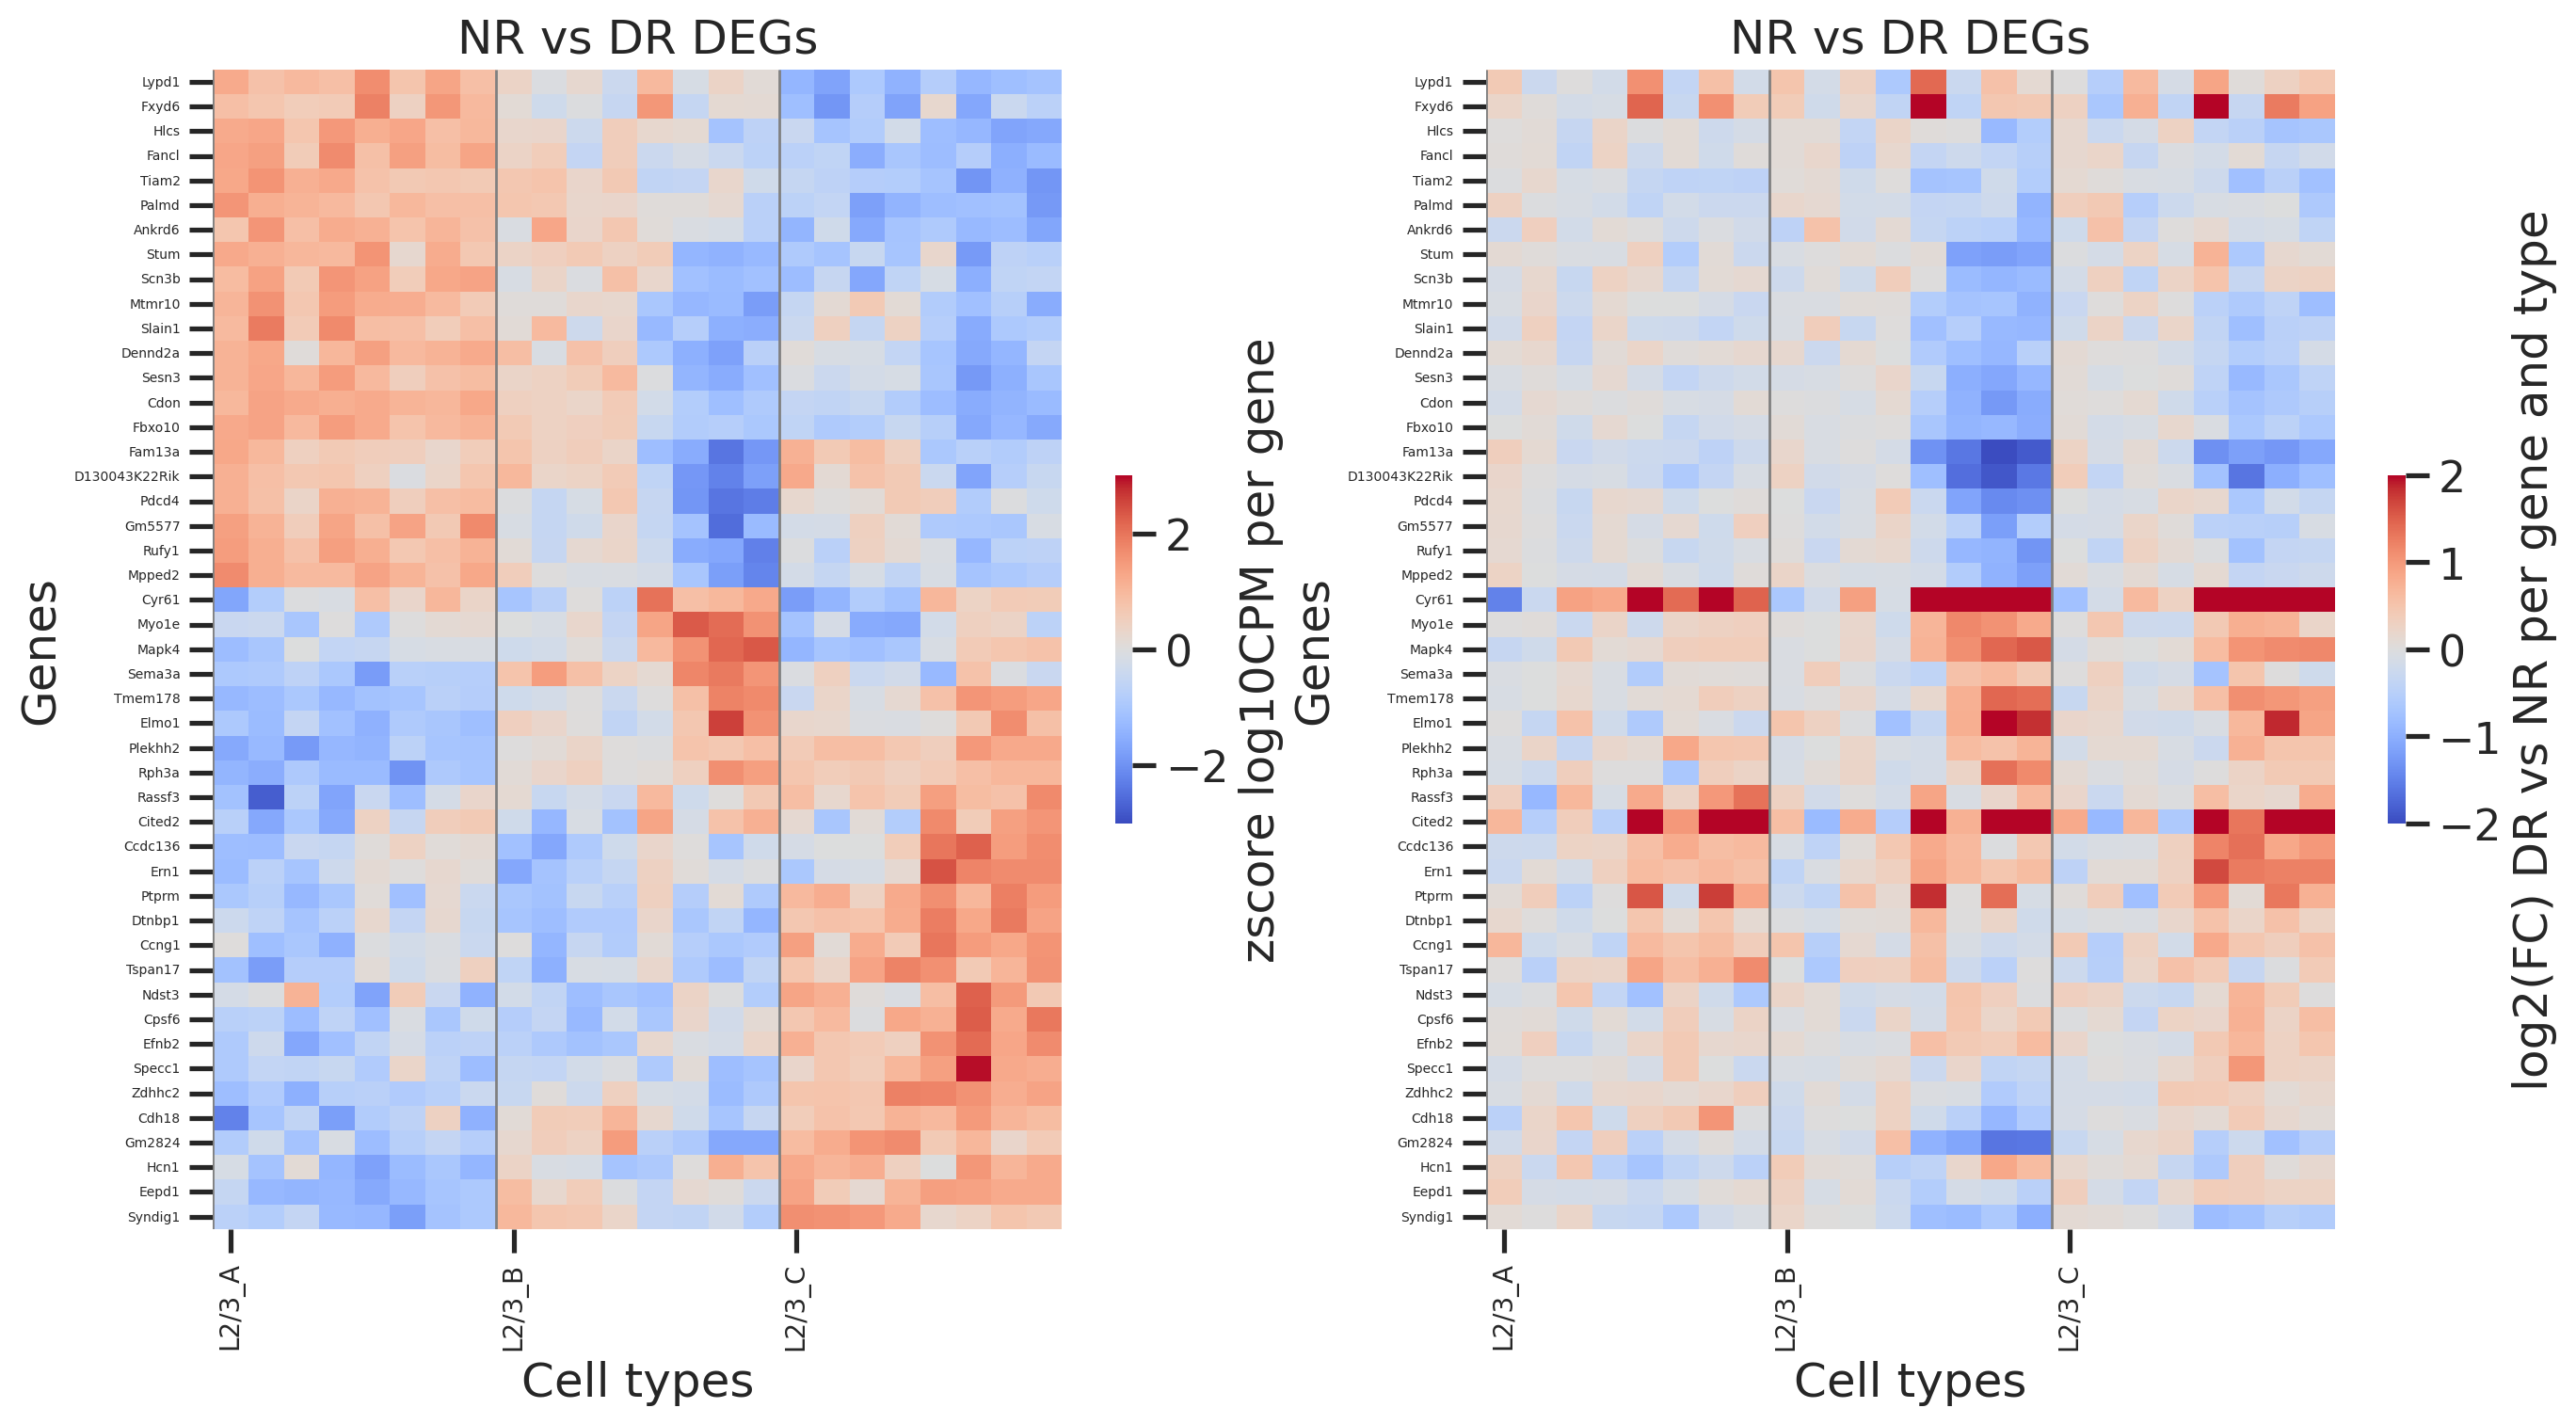

In [106]:
fig, axs = plt.subplots(1,2,figsize=(8*2,8))
ax = axs[0]
sns.heatmap(af[rowidx][:,colidx_expanded], 
            yticklabels=True,
            xticklabels=a2*a3,
            cbar_kws=dict(shrink=0.3, label='zscore log10CPM per gene'),
            cmap='coolwarm', 
            center=0, vmin=-3, vmax=3,
            ax=ax) 
ax.vlines(np.arange(0, a1*a2*a3, a2*a3), 0, a0, color='gray', linewidth=1)
ax.set_xticklabels(col[colidx], rotation=90, fontsize=10)
ax.set_yticklabels(row[rowidx], rotation=0, fontsize=5)
ax.set_ylabel('Genes')
ax.set_xlabel('Cell types')
ax.set_title('NR vs DR DEGs')

ax = axs[1]
sns.heatmap(af_lfc[rowidx][:,colidx_expanded], 
            yticklabels=True, # 20, #degs[rowidx],
            xticklabels=a2*a3,
            cbar_kws=dict(shrink=0.3, label='log2(FC) DR vs NR per gene and type'),
            cmap='coolwarm', 
            center=0, vmin=-2, vmax=2,
            ax=ax) 
ax.vlines(np.arange(0, a1*a2*a3, a2*a3), 0, a0, color='gray', linewidth=1)
ax.set_xticklabels(col[colidx], rotation=90, fontsize=10)
ax.set_yticklabels(row[rowidx], rotation=0, fontsize=5)
ax.set_ylabel('Genes')
ax.set_xlabel('Cell types')
ax.set_title('NR vs DR DEGs')
plt.show()

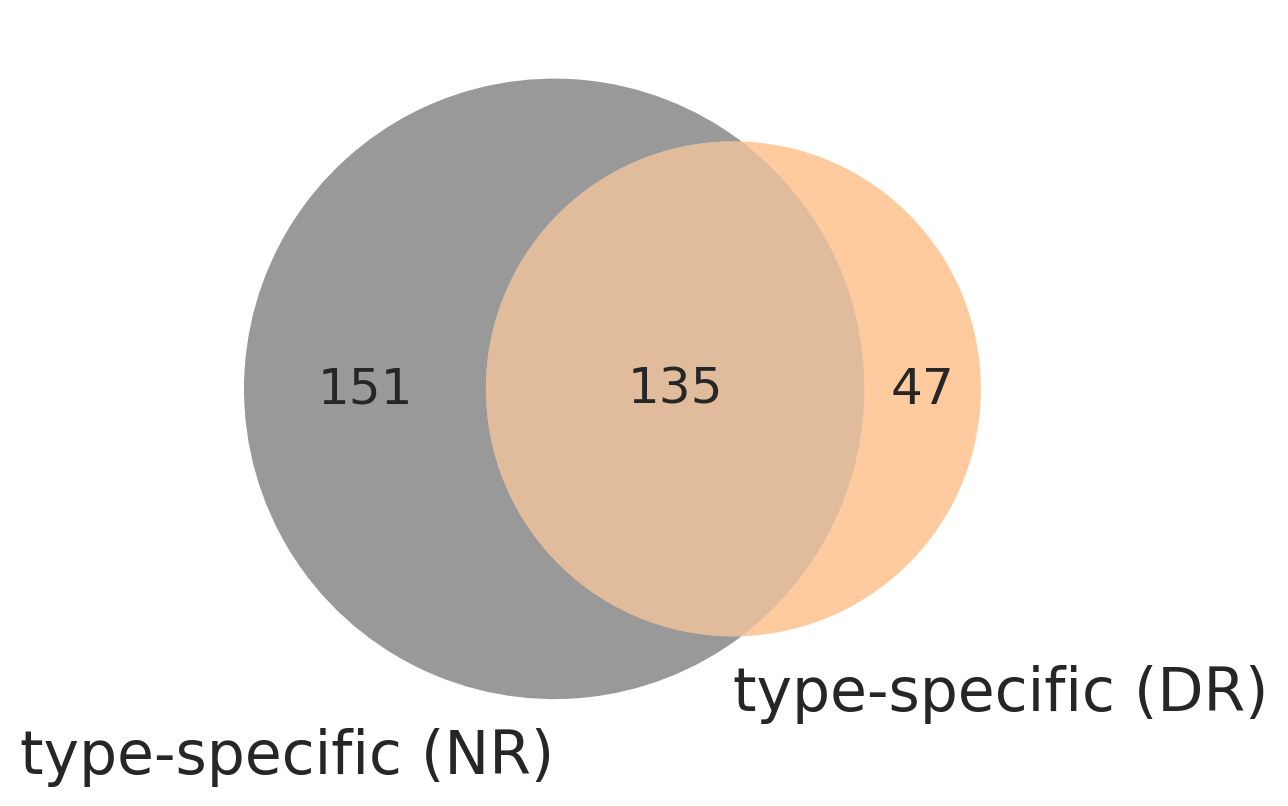

In [122]:
from matplotlib_venn import venn2

a = dfplot[dfplot['isType']].index.values
b = dr_abc_genes
venn2([set(a.tolist()), set(b.tolist())], 
      set_labels=('type-specific (NR)', 'type-specific (DR)'), 
      set_colors=('k', 'C1'),
     )
plt.show()

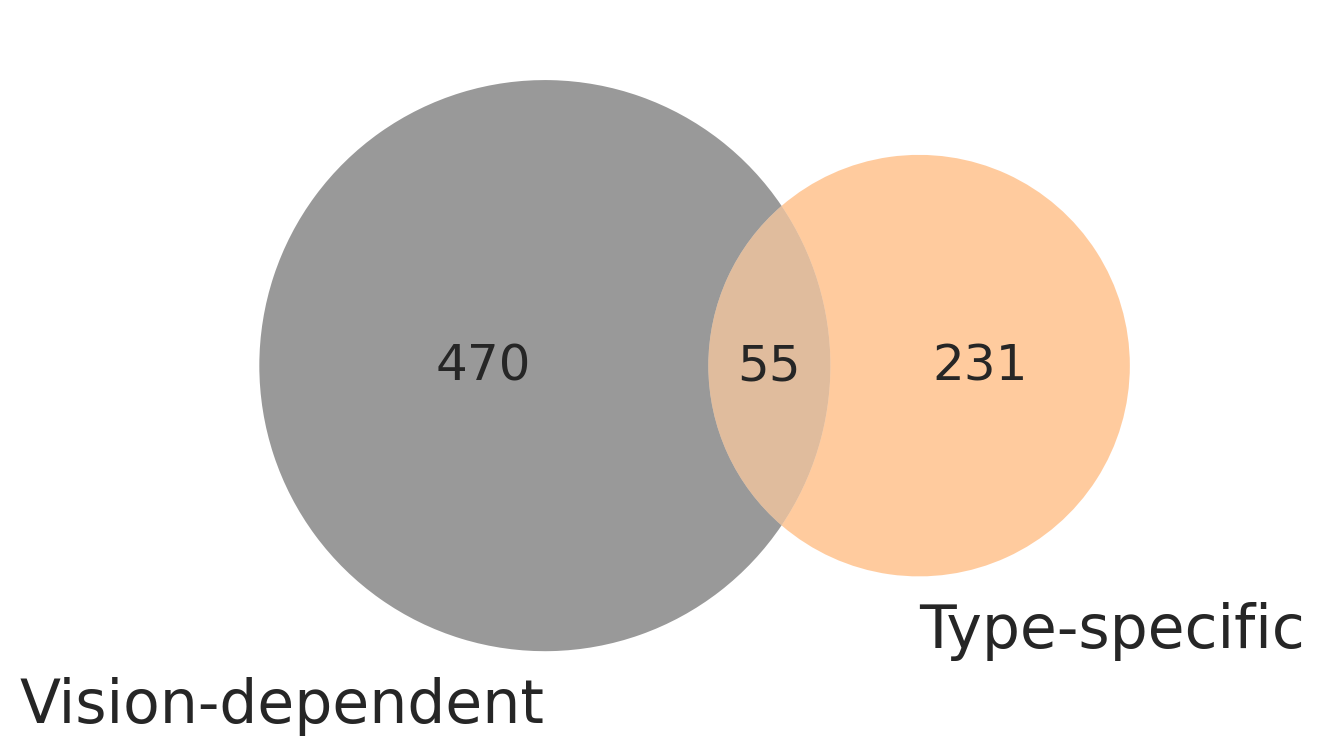

In [126]:
a = dfplot[dfplot['isDR']].index.values
b = dfplot[dfplot['isType']].index.values
venn2([set(a.tolist()), set(b.tolist())], 
      set_labels=('Vision-dependent', 'Type-specific'), 
      set_colors=('k', 'C1'),
     )
plt.show()